In [1]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

#BiocManager::install("clusterProfiler", force = TRUE)
#BiocManager::install("DO.db", force=TRUE)

#install.packages("ontologyIndex")
#install.packages("ggnewscale")


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Installing package(s) 'BiocVersion', 'clusterProfiler'

also installing the dependencies ‘sys’, ‘bitops’, ‘askpass’, ‘zlibbioc’, ‘RCurl’, ‘GenomeInfoDbData’, ‘formatR’, ‘colorspace’, ‘gridGraphics’, ‘bit’, ‘cachem’, ‘curl’, ‘mime’, ‘openssl’, ‘XVector’, ‘GenomeInfoDb’, ‘lambda.r’, ‘futile.options’, ‘lattice’, ‘nlme’, ‘farver’, ‘labeling’, ‘munsell’, ‘viridisLite’, ‘stringi’, ‘tweenr’, ‘polyclip’, ‘RcppEigen’, ‘RcppArmadillo’, ‘ggplotify’, ‘patchwork’, ‘lazyeval’, ‘bit64’, ‘blob’, ‘memoise’, ‘pkgconfig’, ‘plogr’, ‘httr’, ‘png’, ‘Biostrings’, ‘futile.logger’, ‘snow’, ‘BH’, ‘data.table’, ‘gridExtra’, ‘fastmatch’, ‘Matrix’, ‘gtable’, ‘isoband’, ‘MASS’, ‘mgcv’, ‘scales’, ‘withr’, 

In [53]:
library(dplyr)
library(stringr)
library(tidyr)
library(clusterProfiler)
library(ontologyIndex)
library(ggnewscale)

load("../tea/A2TEA_finished.RData")


Attaching package: ‘dplyr’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand




In [100]:
#we use get_ontology from ontologIndex to read the GeneOntology .obo file
#we extract all tags (everything), so that we retain the namespace/aspect info: BP, MF, CC
ont <- get_ontology("../go.obo", extract_tags = "everything")

#filtering of obsolete terms; shortening & renaming (clusterProfiler functions are picky)
ont_short <- as.data.frame(ont) %>%
  dplyr::filter(obsolete == FALSE) %>%
  dplyr::select(id, name, namespace) %>%
  dplyr::rename(GO = id) %>%
  dplyr::rename(Description = name)
row.names(ont_short) <- NULL

#split into aspect specific sets
ont_BP <- ont_short %>%
  filter(namespace == "biological_process")

ont_MF <- ont_short %>%
  filter(namespace == "molecular_function")

ont_CC <- ont_short %>%
  filter(namespace == "cellular_component")

Enrichment analysis can be performed on HOG level
- this entails that we have non-redundant GO terms for all genes in the orthologous group
- however, on HOG level we don't possess log2FC values 
- thus we compute sets for pure HOG analysis (1) as well as diff. exp. genes in the HOGs (2)

In [102]:
#HOG level

#input for buildGomap needs to be long format - one GO term per row
SFA_OG_clusterProfiler <- SFA_OG_level$hypothesis_2 %>%
  dplyr::select(HOG, `Gene-Ontology-Term`) %>%
  dplyr::mutate(
      `Gene-Ontology-Term` = str_remove_all(`Gene-Ontology-Term`, "NA, |, NA") 
    ) %>% 
    #remove lines with only NA in Gene-Ontology-Term column
  dplyr::filter(!str_detect(`Gene-Ontology-Term`, 'NA')) %>%
  relocate(`Gene-Ontology-Term`, .before = HOG) %>%
  dplyr::rename(ID = `Gene-Ontology-Term`) %>%
  dplyr::rename(geneID = HOG) %>%
  separate_rows(ID, sep = ",") %>%
  #removing whitespace
  dplyr::mutate(
    ID = str_trim(ID, side = c("both"))
  ) %>%
  dplyr::mutate(
    geneID = str_trim(geneID, side = c("both"))
  ) 
  
#create subsets for the 3 ontology aspects
SFA_OG_clusterProfiler_BP <- SFA_OG_clusterProfiler %>%
  filter(ID %in% ont_BP$GO)

SFA_OG_clusterProfiler_MF <- SFA_OG_clusterProfiler %>%
  filter(ID %in% ont_MF$GO)

SFA_OG_clusterProfiler_CC <- SFA_OG_clusterProfiler %>%
  filter(ID %in% ont_CC$GO)

#important: buildGOmap only functions with data.frame input NOT with tibbles..
SFA_OG_clusterProfiler_BP <- as.data.frame(SFA_OG_clusterProfiler_BP)
SFA_OG_clusterProfiler_MF <- as.data.frame(SFA_OG_clusterProfiler_MF)
SFA_OG_clusterProfiler_CC <- as.data.frame(SFA_OG_clusterProfiler_CC)

OG_GOmap_BP <- buildGOmap(gomap = SFA_OG_clusterProfiler_BP[1:1000,])
OG_GOmap_MF <- buildGOmap(gomap = SFA_OG_clusterProfiler_MF[1:1000,])
OG_GOmap_CC <- buildGOmap(gomap = SFA_OG_clusterProfiler_CC[1:1000,])

#head(OG_GOmap_BP)
#head(OG_GOmap_MF)
#head(OG_GOmap_CC)

GO,Gene
<chr>,<fct>
GO:0000723,N0.HOG0000000
GO:0006281,N0.HOG0000000
GO:0006310,N0.HOG0000000
GO:0006508,N0.HOG0000000
GO:0006974,N0.HOG0000000
GO:0032508,N0.HOG0000000
GO:0016926,N0.HOG0000000
GO:0009909,N0.HOG0000000
GO:0009911,N0.HOG0000000


GO,Gene
<chr>,<fct>
GO:0000166,N0.HOG0000000
GO:0003678,N0.HOG0000000
GO:0004386,N0.HOG0000000
GO:0005524,N0.HOG0000000
GO:0008234,N0.HOG0000000
GO:0016787,N0.HOG0000000
GO:0008233,N0.HOG0000000
GO:0019900,N0.HOG0000000
GO:0070139,N0.HOG0000000


GO,Gene
<chr>,<fct>
GO:0005634,N0.HOG0000000
GO:0016020,N0.HOG0000000
GO:0031965,N0.HOG0000000
GO:0005737,N0.HOG0000000
GO:0009506,N0.HOG0000000
GO:0016021,N0.HOG0000000
GO:0005840,N0.HOG0000000
GO:0005681,N0.HOG0000000
GO:0005682,N0.HOG0000000


In [152]:
#interesting genes level (those inside the interesting HOGs)

#input for buildGomap needs to be long format - one GO term per row
SFA_genes_clusterProfiler <- SFA[[2]] %>%
  dplyr::select(`Protein-Accession`, `Gene-Ontology-Term`) %>%
  dplyr::mutate(
      `Gene-Ontology-Term` = str_remove_all(`Gene-Ontology-Term`, "NA, |, NA") 
    ) %>% 
    #remove lines with only NA in Gene-Ontology-Term column
  dplyr::filter(!str_detect(`Gene-Ontology-Term`, 'NA')) %>%
  relocate(`Gene-Ontology-Term`, .before = `Protein-Accession`) %>%
  dplyr::rename(ID = `Gene-Ontology-Term`) %>%
  dplyr::rename(geneID = `Protein-Accession`) %>%
  separate_rows(ID, sep = ",") %>%
  #removing whitespace
  dplyr::mutate(
    ID = str_trim(ID, side = c("both"))
  ) %>%
  dplyr::mutate(
    geneID = str_trim(geneID, side = c("both"))
  ) 
  
#create subsets for the 3 ontology aspects
SFA_genes_clusterProfiler_BP <- SFA_genes_clusterProfiler %>%
  filter(ID %in% ont_BP$GO)

SFA_genes_clusterProfiler_MF <- SFA_genes_clusterProfiler %>%
  filter(ID %in% ont_MF$GO)

SFA_genes_clusterProfiler_CC <- SFA_genes_clusterProfiler %>%
  filter(ID %in% ont_CC$GO)

#important: buildGOmap only functions with data.frame input NOT with tibbles..
SFA_genes_clusterProfiler_BP <- as.data.frame(SFA_genes_clusterProfiler_BP)
SFA_genes_clusterProfiler_MF <- as.data.frame(SFA_genes_clusterProfiler_MF)
SFA_genes_clusterProfiler_CC <- as.data.frame(SFA_genes_clusterProfiler_CC)

Genes_GOmap_BP <- buildGOmap(gomap = SFA_genes_clusterProfiler_BP[1:10000,])
Genes_GOmap_MF <- buildGOmap(gomap = SFA_genes_clusterProfiler_MF[1:10000,])
Genes_GOmap_CC <- buildGOmap(gomap = SFA_genes_clusterProfiler_CC[1:10000,])

head(Genes_GOmap_BP)
head(Genes_GOmap_MF)
head(Genes_GOmap_CC)

,GO,Gene
,<chr>,<fct>
1,GO:0006811,HORVU0Hr1G001040
2,GO:0006816,HORVU0Hr1G001040
3,GO:0070588,HORVU0Hr1G001040
4,GO:0006810,HORVU0Hr1G001040
5,GO:0008150,HORVU0Hr1G001040
6,GO:0051179,HORVU0Hr1G001040


,GO,Gene
,<chr>,<fct>
1,GO:0000166,HORVU0Hr1G001040
2,GO:0005388,HORVU0Hr1G001040
3,GO:0005516,HORVU0Hr1G001040
4,GO:0005524,HORVU0Hr1G001040
5,GO:0019829,HORVU0Hr1G001040
6,GO:0046872,HORVU0Hr1G001040


,GO,Gene
,<chr>,<fct>
1,GO:0005887,HORVU0Hr1G001040
2,GO:0016020,HORVU0Hr1G001040
3,GO:0016021,HORVU0Hr1G001040
4,GO:0043231,HORVU0Hr1G001040
5,GO:0005575,HORVU0Hr1G001040
6,GO:0005886,HORVU0Hr1G001040


In [128]:
#we have to define an interesting set (expansion+diff.exp.) we could for instance filter based on tea_value
int_HOGs <- HOG_level_list[[2]] %>%
  filter(tea_value < 0.05) %>%
  pull(HOG)


#significantly expressed genes based on the interesting HOG definition prior can be extracted

h_expanded_in <- unlist(str_split(hypotheses$expanded_in[2], ";"))
h_compared_to <- unlist(str_split(hypotheses$compared_to[2], ";"))
h_species <- unique(c(h_expanded_in, h_compared_to))


int_genes <- HOG_DE.a2tea %>%
  filter(HOG %in% int_HOGs) %>%
  filter(species %in% h_species) %>%
  filter(significant == "yes") %>%
  pull(gene)

In [225]:
resGO <- enricher(
  int_genes,
  TERM2GENE=Genes_GOmap_BP,
  TERM2NAME=ont_BP
)

In [156]:
#ttt$ID
resGO@result #%>%
#  filter(is.na(Description))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0006952,GO:0006952,defense response,18/66,326/3478,2.021738e-05,0.002985177,0.002328993,HORVU1Hr1G005470/HORVU1Hr1G005520/HORVU2Hr1G005310/HORVU2Hr1G005330/HORVU2Hr1G005350/HORVU2Hr1G044520/HORVU2Hr1G044640/HORVU2Hr1G044650/HORVU2Hr1G044680/HORVU4Hr1G000310/HORVU4Hr1G000350/HORVU5Hr1G122180/HORVU5Hr1G122190/HORVU6Hr1G053090/HORVU6Hr1G082880/HORVU6Hr1G092500/HORVU7Hr1G021740/HORVU7Hr1G106510,18
GO:0098754,GO:0098754,detoxification,8/66,65/3478,2.341316e-05,0.002985177,0.002328993,HORVU1Hr1G091930/HORVU3Hr1G010630/HORVU3Hr1G036780/HORVU3Hr1G036790/HORVU3Hr1G036820/HORVU3Hr1G083190/HORVU7Hr1G006250/HORVU7Hr1G045600,8
GO:0098869,GO:0098869,cellular oxidant detoxification,7/66,55/3478,6.340307e-05,0.003259404,0.002542941,HORVU1Hr1G091930/HORVU3Hr1G036780/HORVU3Hr1G036790/HORVU3Hr1G036820/HORVU3Hr1G083190/HORVU7Hr1G006250/HORVU7Hr1G045600,7
GO:0097237,GO:0097237,cellular response to toxic substance,7/66,56/3478,7.138317e-05,0.003259404,0.002542941,HORVU1Hr1G091930/HORVU3Hr1G036780/HORVU3Hr1G036790/HORVU3Hr1G036820/HORVU3Hr1G083190/HORVU7Hr1G006250/HORVU7Hr1G045600,7
GO:1990748,GO:1990748,cellular detoxification,7/66,56/3478,7.138317e-05,0.003259404,0.002542941,HORVU1Hr1G091930/HORVU3Hr1G036780/HORVU3Hr1G036790/HORVU3Hr1G036820/HORVU3Hr1G083190/HORVU7Hr1G006250/HORVU7Hr1G045600,7
GO:0009636,GO:0009636,response to toxic substance,8/66,78/3478,8.947383e-05,0.003259404,0.002542941,HORVU1Hr1G091930/HORVU3Hr1G010630/HORVU3Hr1G036780/HORVU3Hr1G036790/HORVU3Hr1G036820/HORVU3Hr1G083190/HORVU7Hr1G006250/HORVU7Hr1G045600,8
GO:0042742,GO:0042742,defense response to bacterium,8/66,78/3478,8.947383e-05,0.003259404,0.002542941,HORVU2Hr1G005310/HORVU2Hr1G005330/HORVU2Hr1G005350/HORVU2Hr1G044520/HORVU2Hr1G044640/HORVU2Hr1G044650/HORVU2Hr1G044680/HORVU6Hr1G053090,8
GO:0007166,GO:0007166,cell surface receptor signaling pathway,6/66,52/3478,3.808483e-04,0.010789868,0.008418101,HORVU1Hr1G015420/HORVU1Hr1G076210/HORVU5Hr1G087560/HORVU5Hr1G089840/HORVU6Hr1G053090/HORVU6Hr1G053120,6
GO:0009617,GO:0009617,response to bacterium,8/66,96/3478,3.861235e-04,0.010789868,0.008418101,HORVU2Hr1G005310/HORVU2Hr1G005330/HORVU2Hr1G005350/HORVU2Hr1G044520/HORVU2Hr1G044640/HORVU2Hr1G044650/HORVU2Hr1G044680/HORVU6Hr1G053090,8


### Visualizations

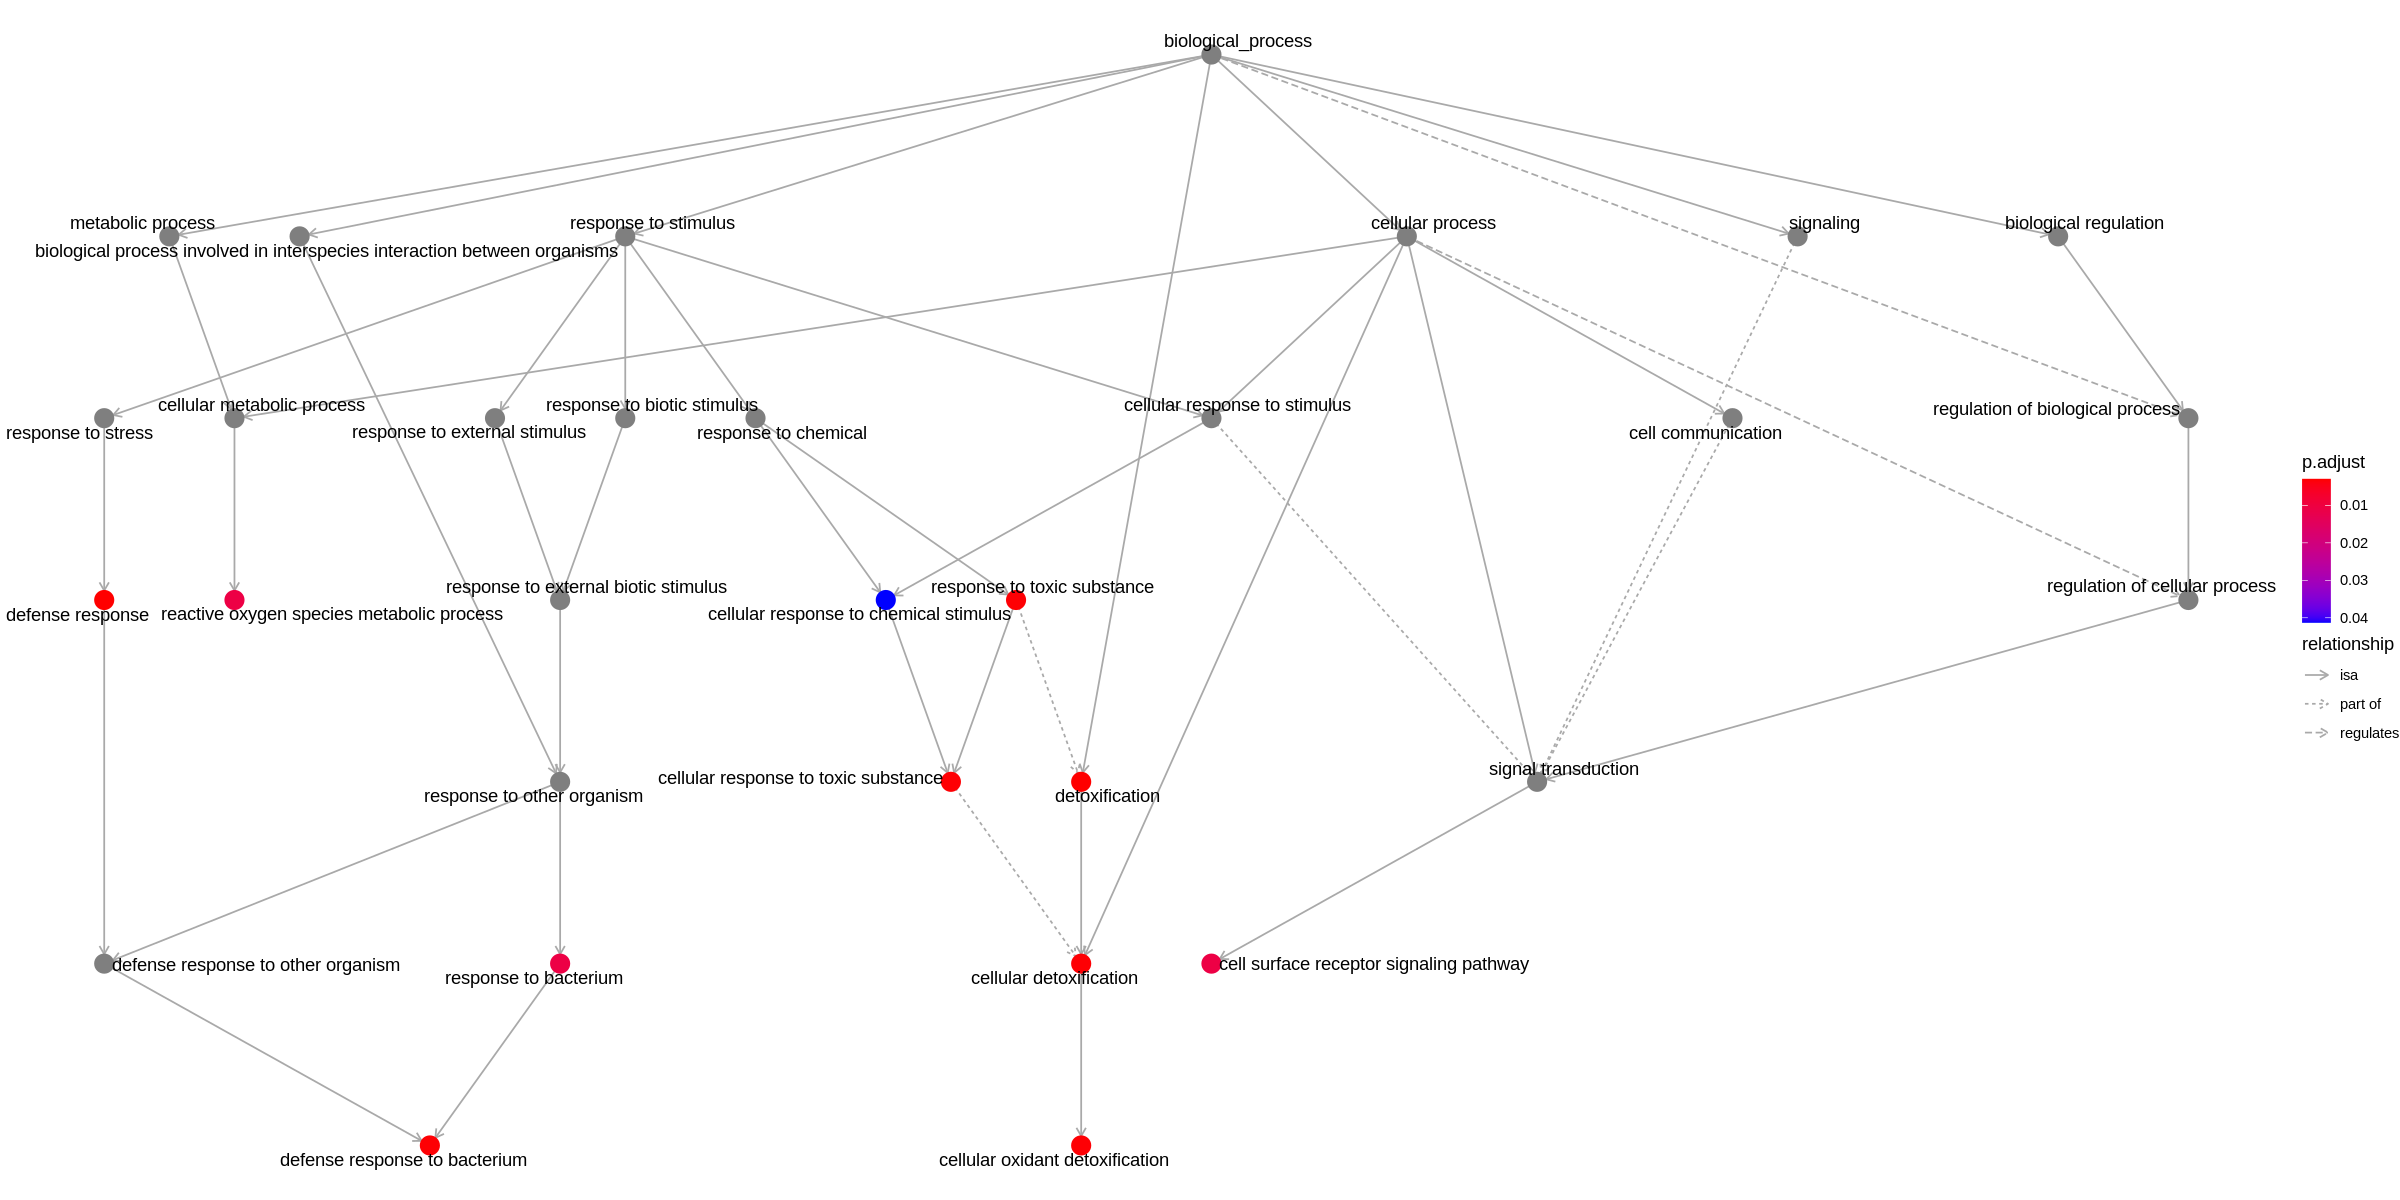

In [226]:
#need to assign an ontology - otherwise goplot() doesn't work..
#surprisingly, this is the only one of the plots that is picky..
resGO@ontology <- "BP"
goplot(resGO)

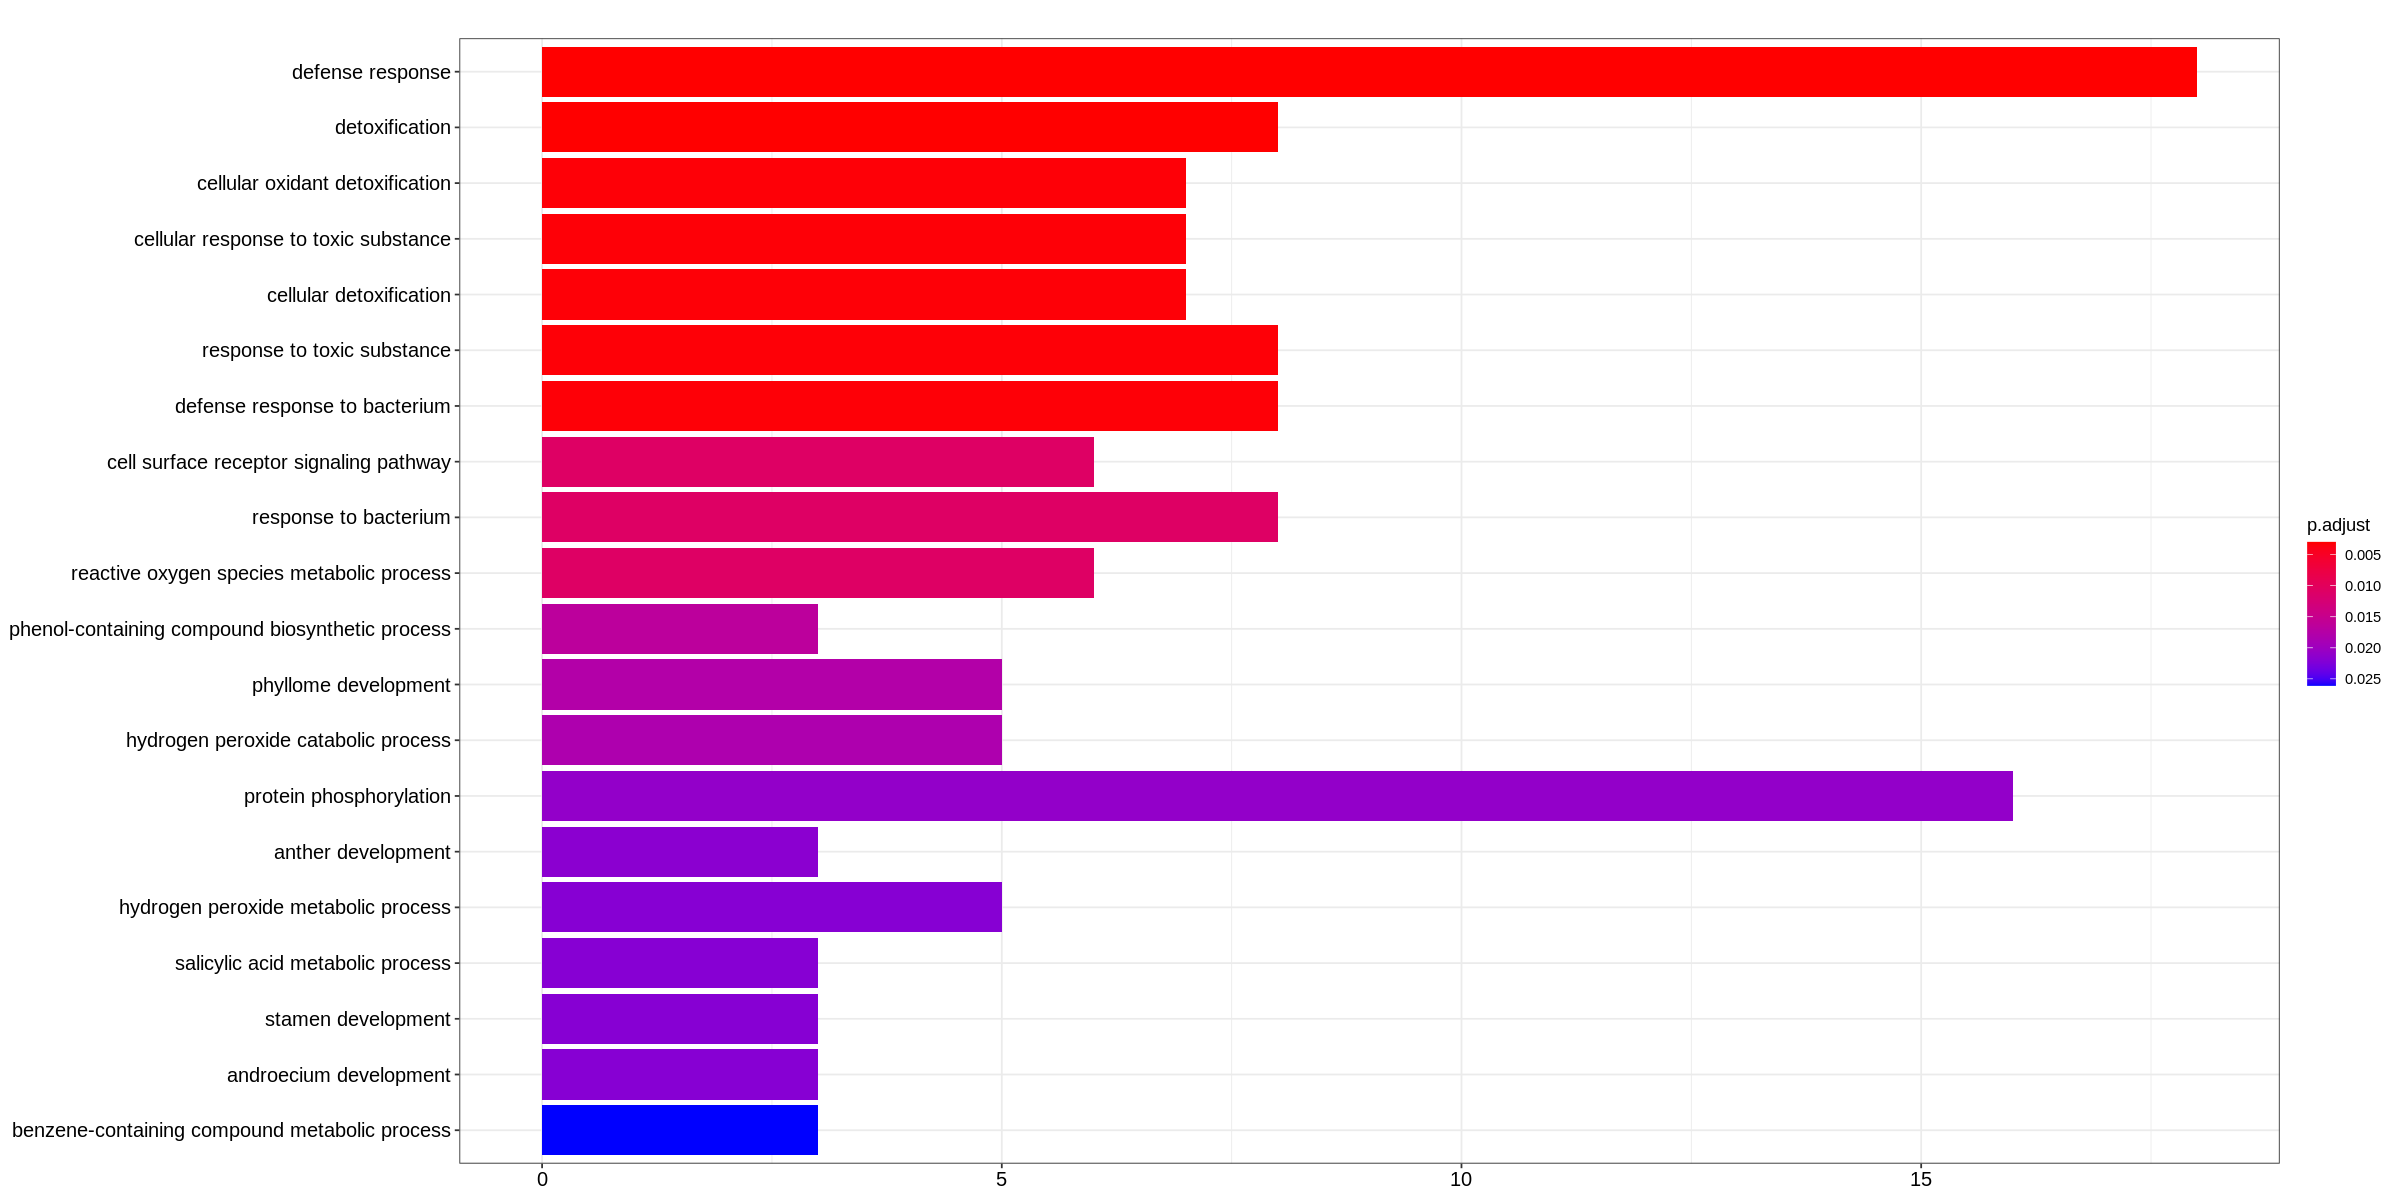

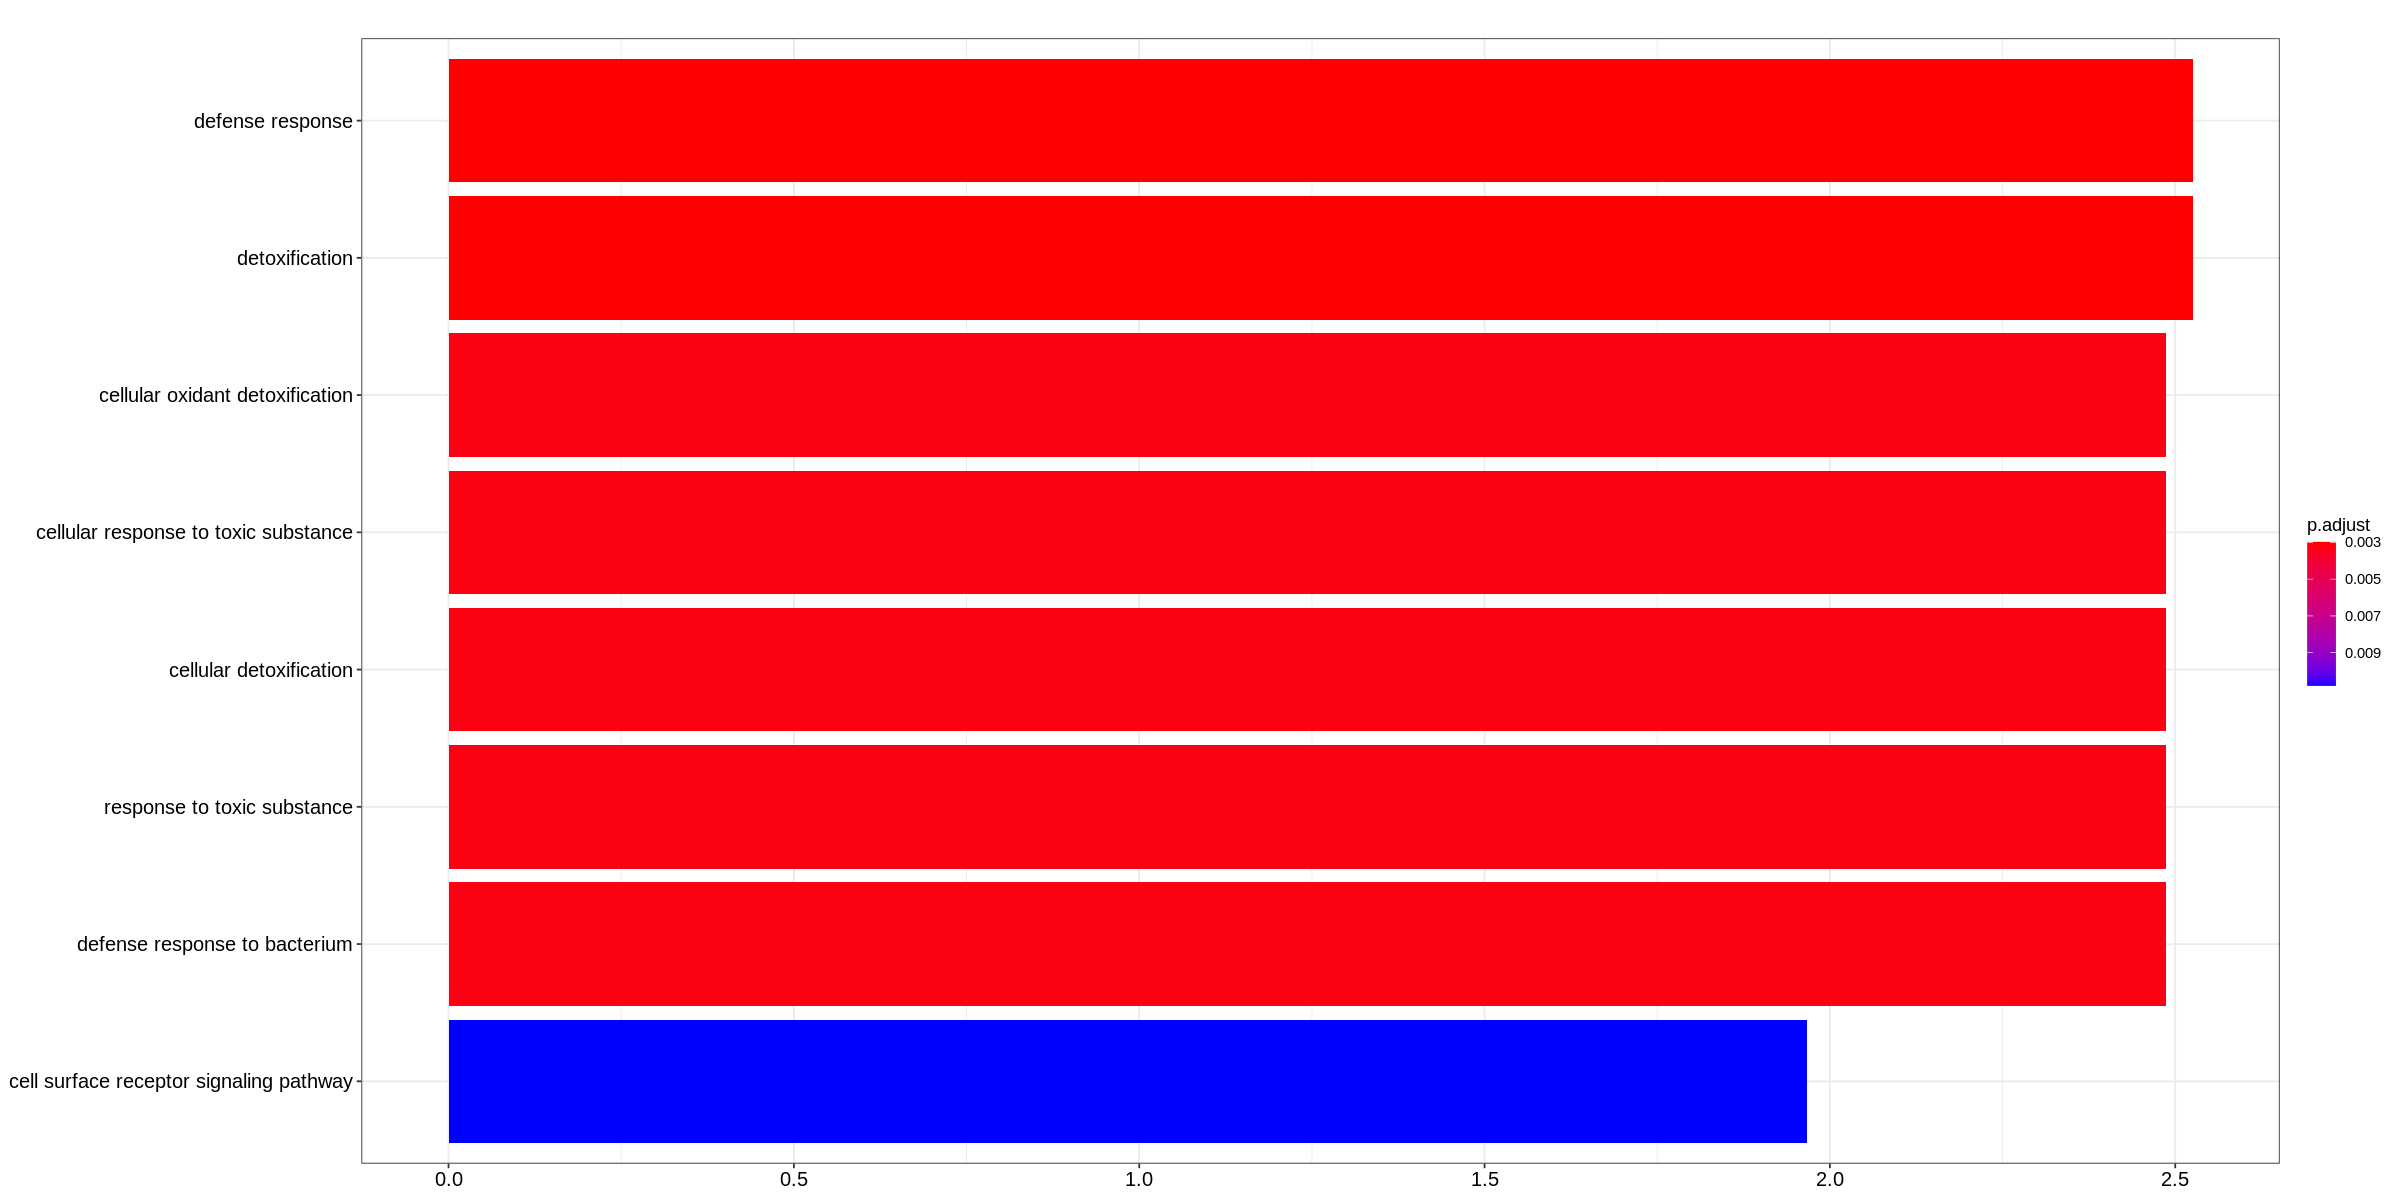

In [158]:
library(enrichplot)
options(repr.plot.width=20, repr.plot.height=10)


barplot(resGO, showCategory=20)

mutate(resGO, qscore = -log(p.adjust, base=10)) %>% 
    barplot(x="qscore")

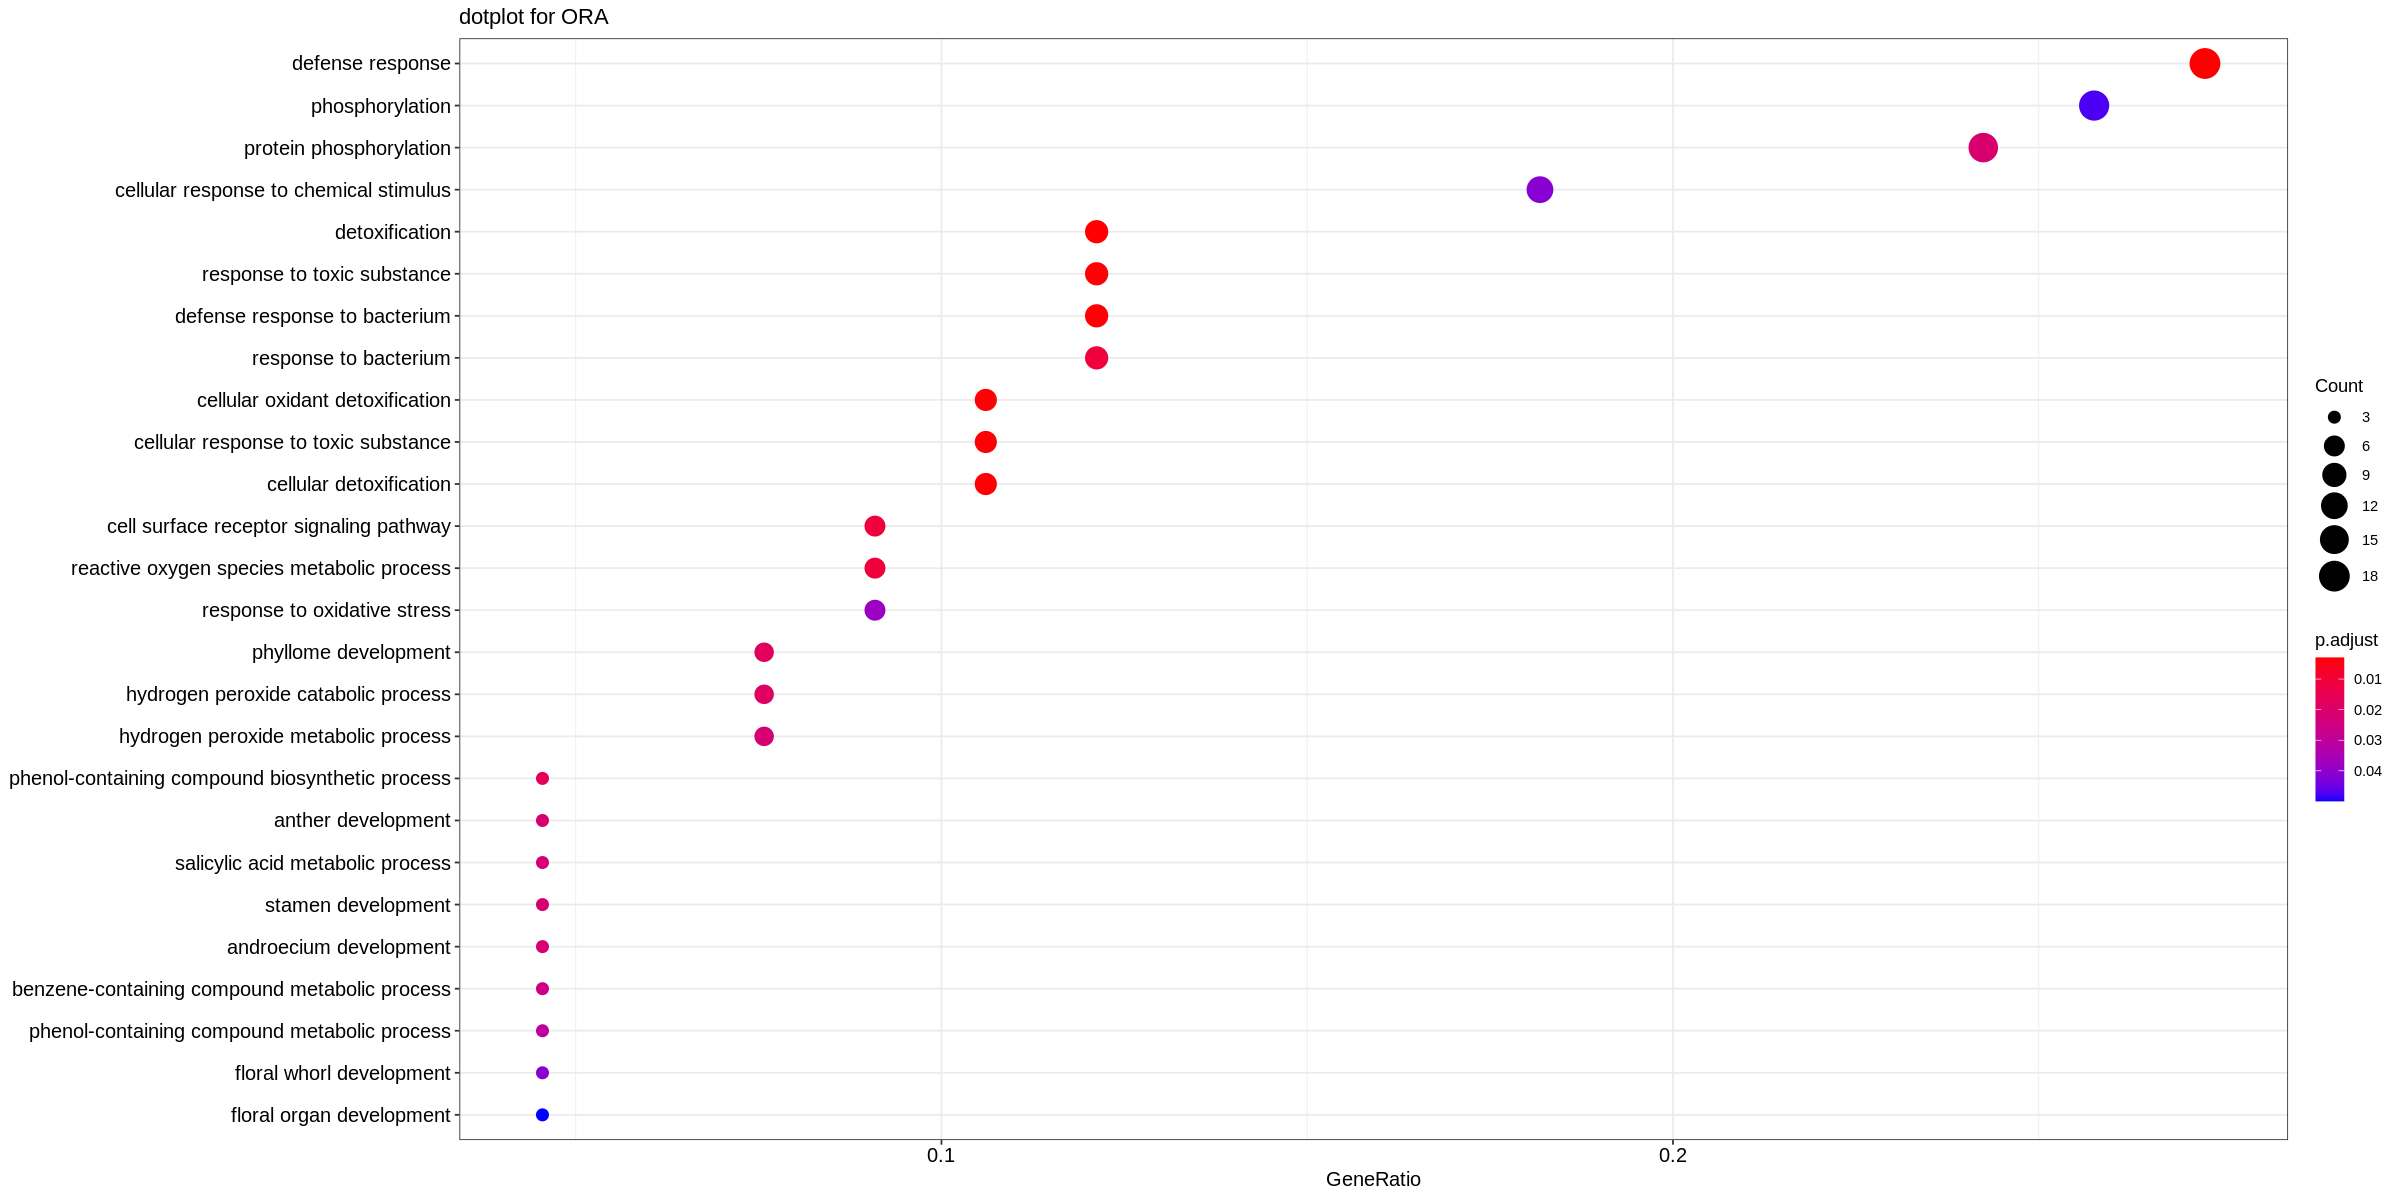

In [159]:
dotplot(resGO, showCategory=30) + ggtitle("dotplot for ORA")

In [191]:
#clusterProfiler wants named integer for passing the log2FoldChange values for plots
qlfc <- HOG_DE.a2tea %>%
  select(gene, log2FoldChange) %>%
  rename(foldChange = log2FoldChange) %>%
  filter(gene %in% int_genes)

qlfc_vec <- qlfc$foldChange
names(qlfc_vec) <- qlfc$gene

,gene,foldChange
,<chr>,<dbl>
1,HORVU0Hr1G006050,-4.030889
2,HORVU0Hr1G007690,-1.552205
3,HORVU0Hr1G008590,-1.262754
4,HORVU0Hr1G011430,-2.066192
5,HORVU0Hr1G011720,-1.253754
6,HORVU0Hr1G014630,-3.164739


HORVU0Hr1G006050 HORVU0Hr1G007690 HORVU0Hr1G008590 HORVU0Hr1G011430 
       -4.030889        -1.552205        -1.262754        -2.066192 
HORVU0Hr1G011720 HORVU0Hr1G014630 
       -1.253754        -3.164739

In [202]:
?cnetplot

Warning message in seq_len(head.end.idx):
“first element used of 'length.out' argument”
ERROR while rich displaying an object: Error in seq_len(head.end.idx): argument must be coercible to non-negative integer

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_conte

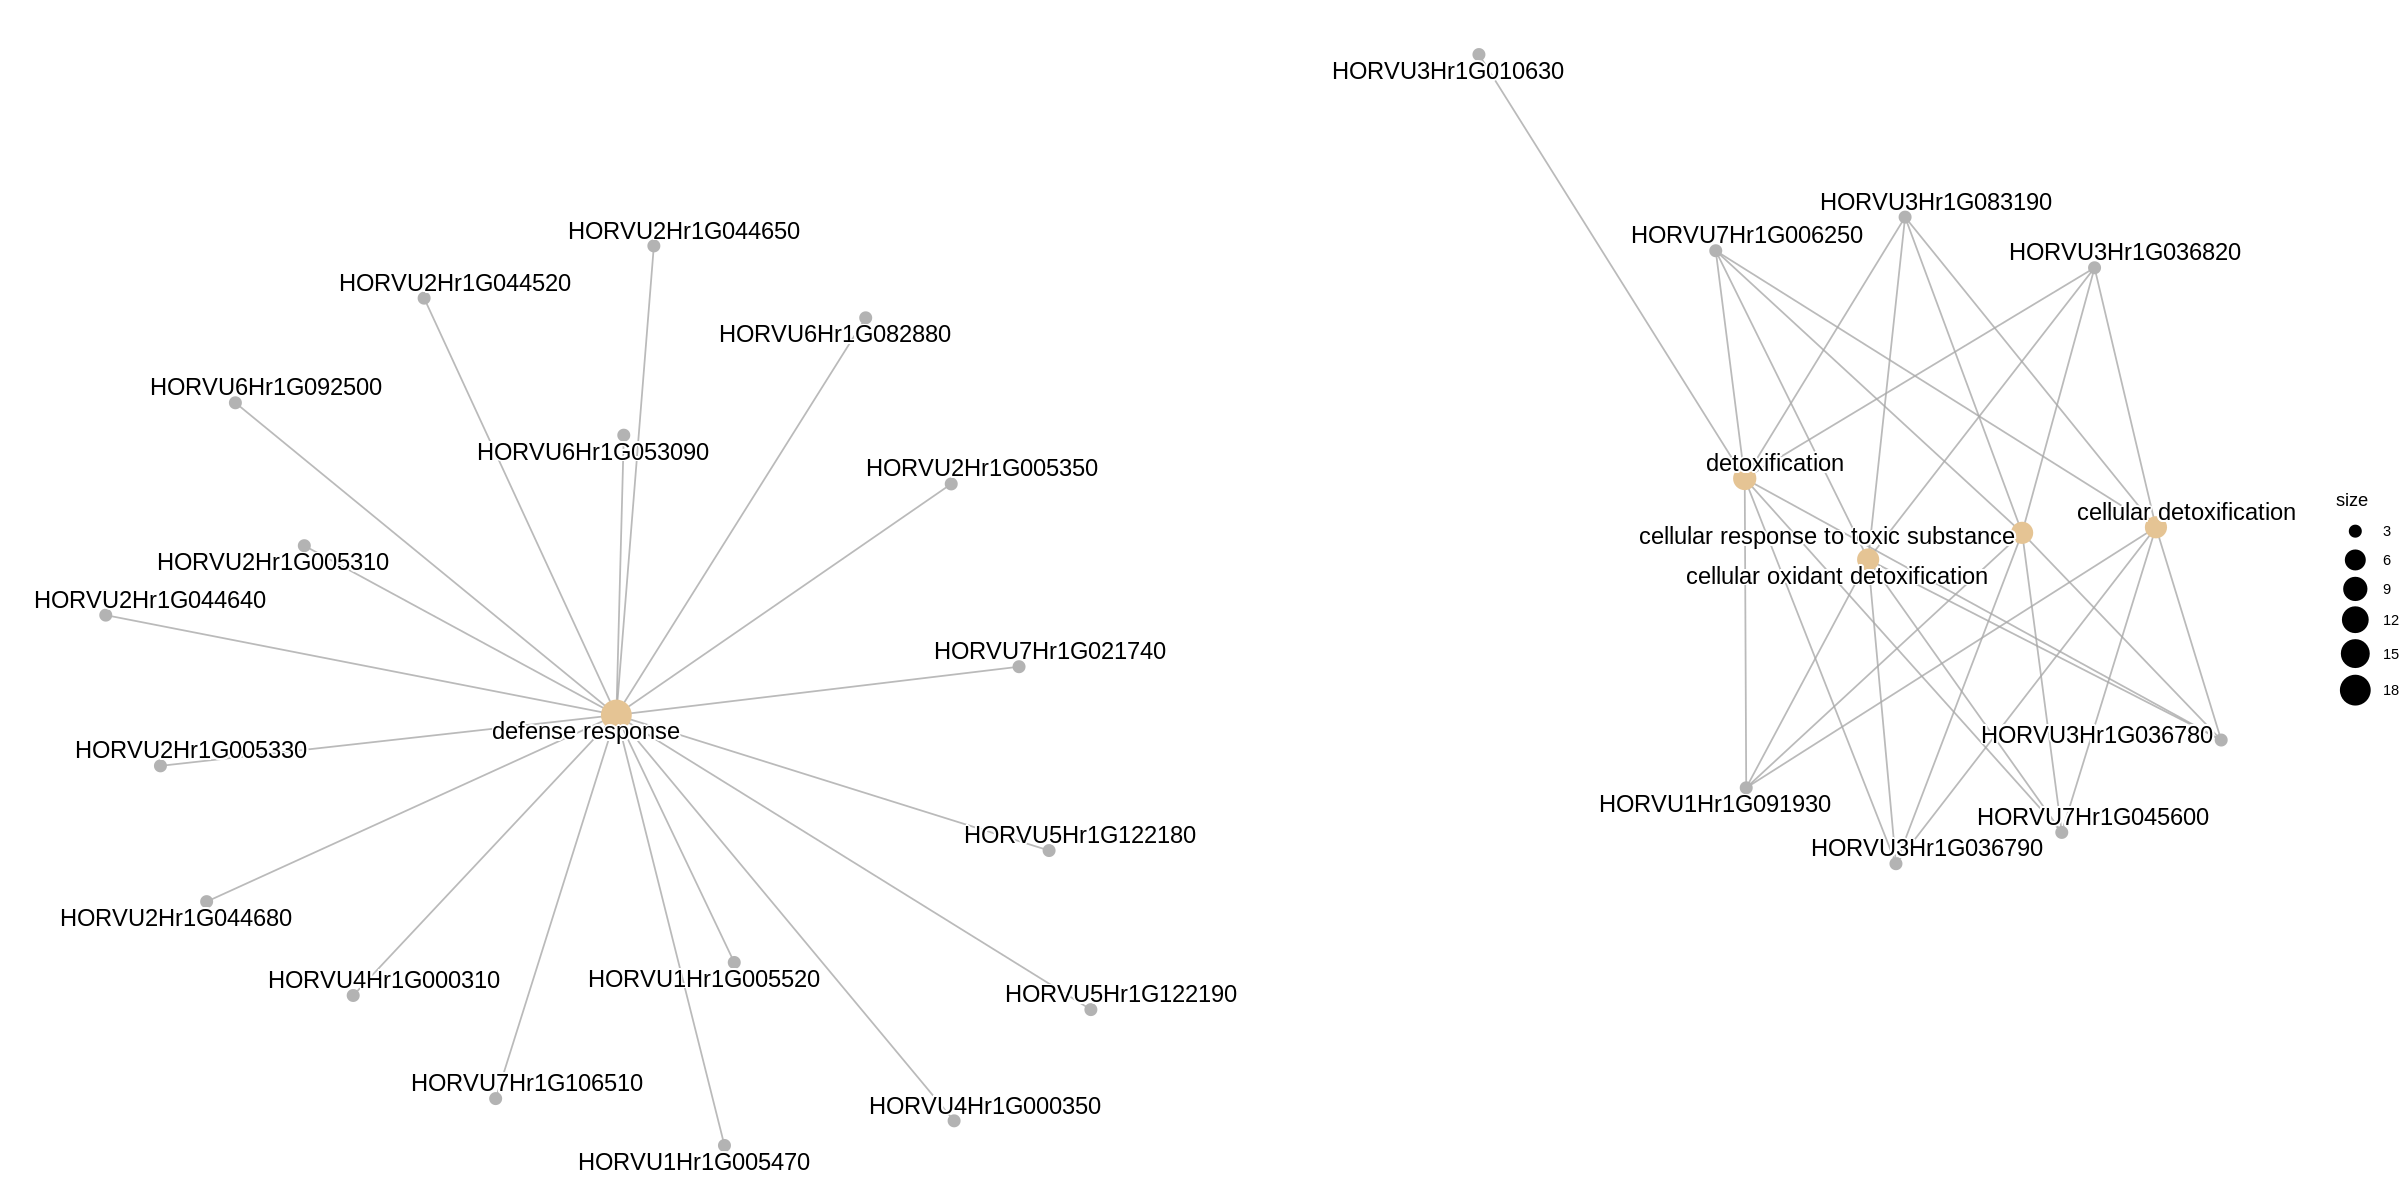

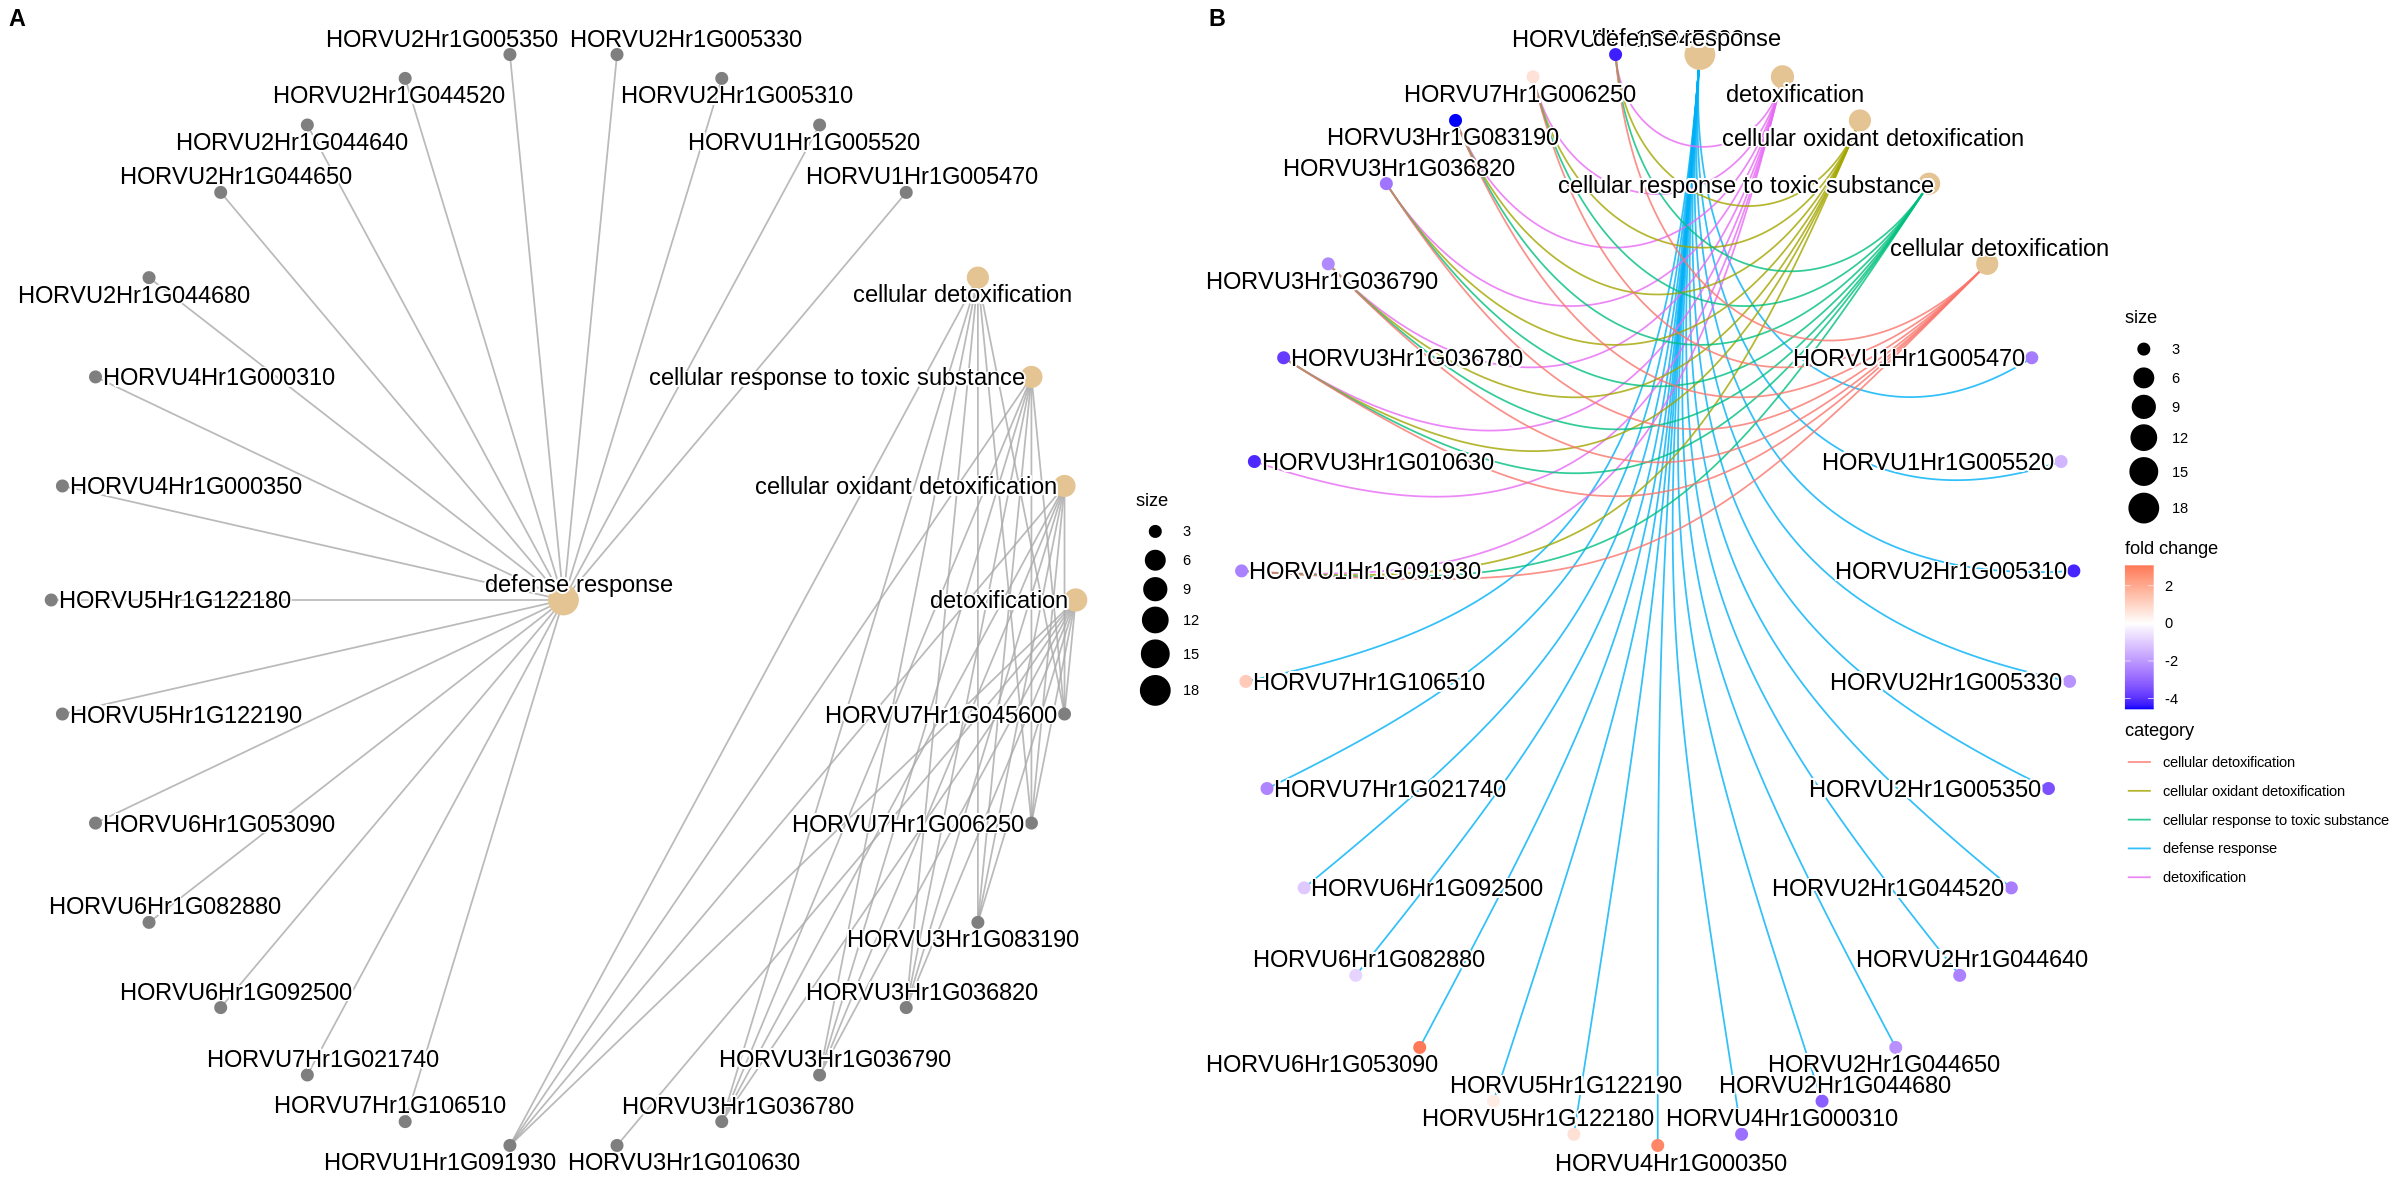

In [203]:
# Gene Concept Network
## convert gene ID to Symbol


##using gene level data - allows for log2FC

p1 <- cnetplot(resGO, categorySize="pvalue", layout = "kk")
p1

p2 <- cnetplot(resGO, categorySize="pvalue", foldChange=geneList, layout = "star")

p3 <- cnetplot(resGO, 
               showCategory = 5, 
               categorySize="pvalue", 
               foldChange=qlfc_vec,
               circular = TRUE, 
               colorEdge = TRUE)

## categorySize can be scaled by 'pvalue' or 'geneNum'
cowplot::plot_grid(p2, p3, ncol=2, labels=LETTERS[1:2], rel_widths=c(.8, .8, 1.2))

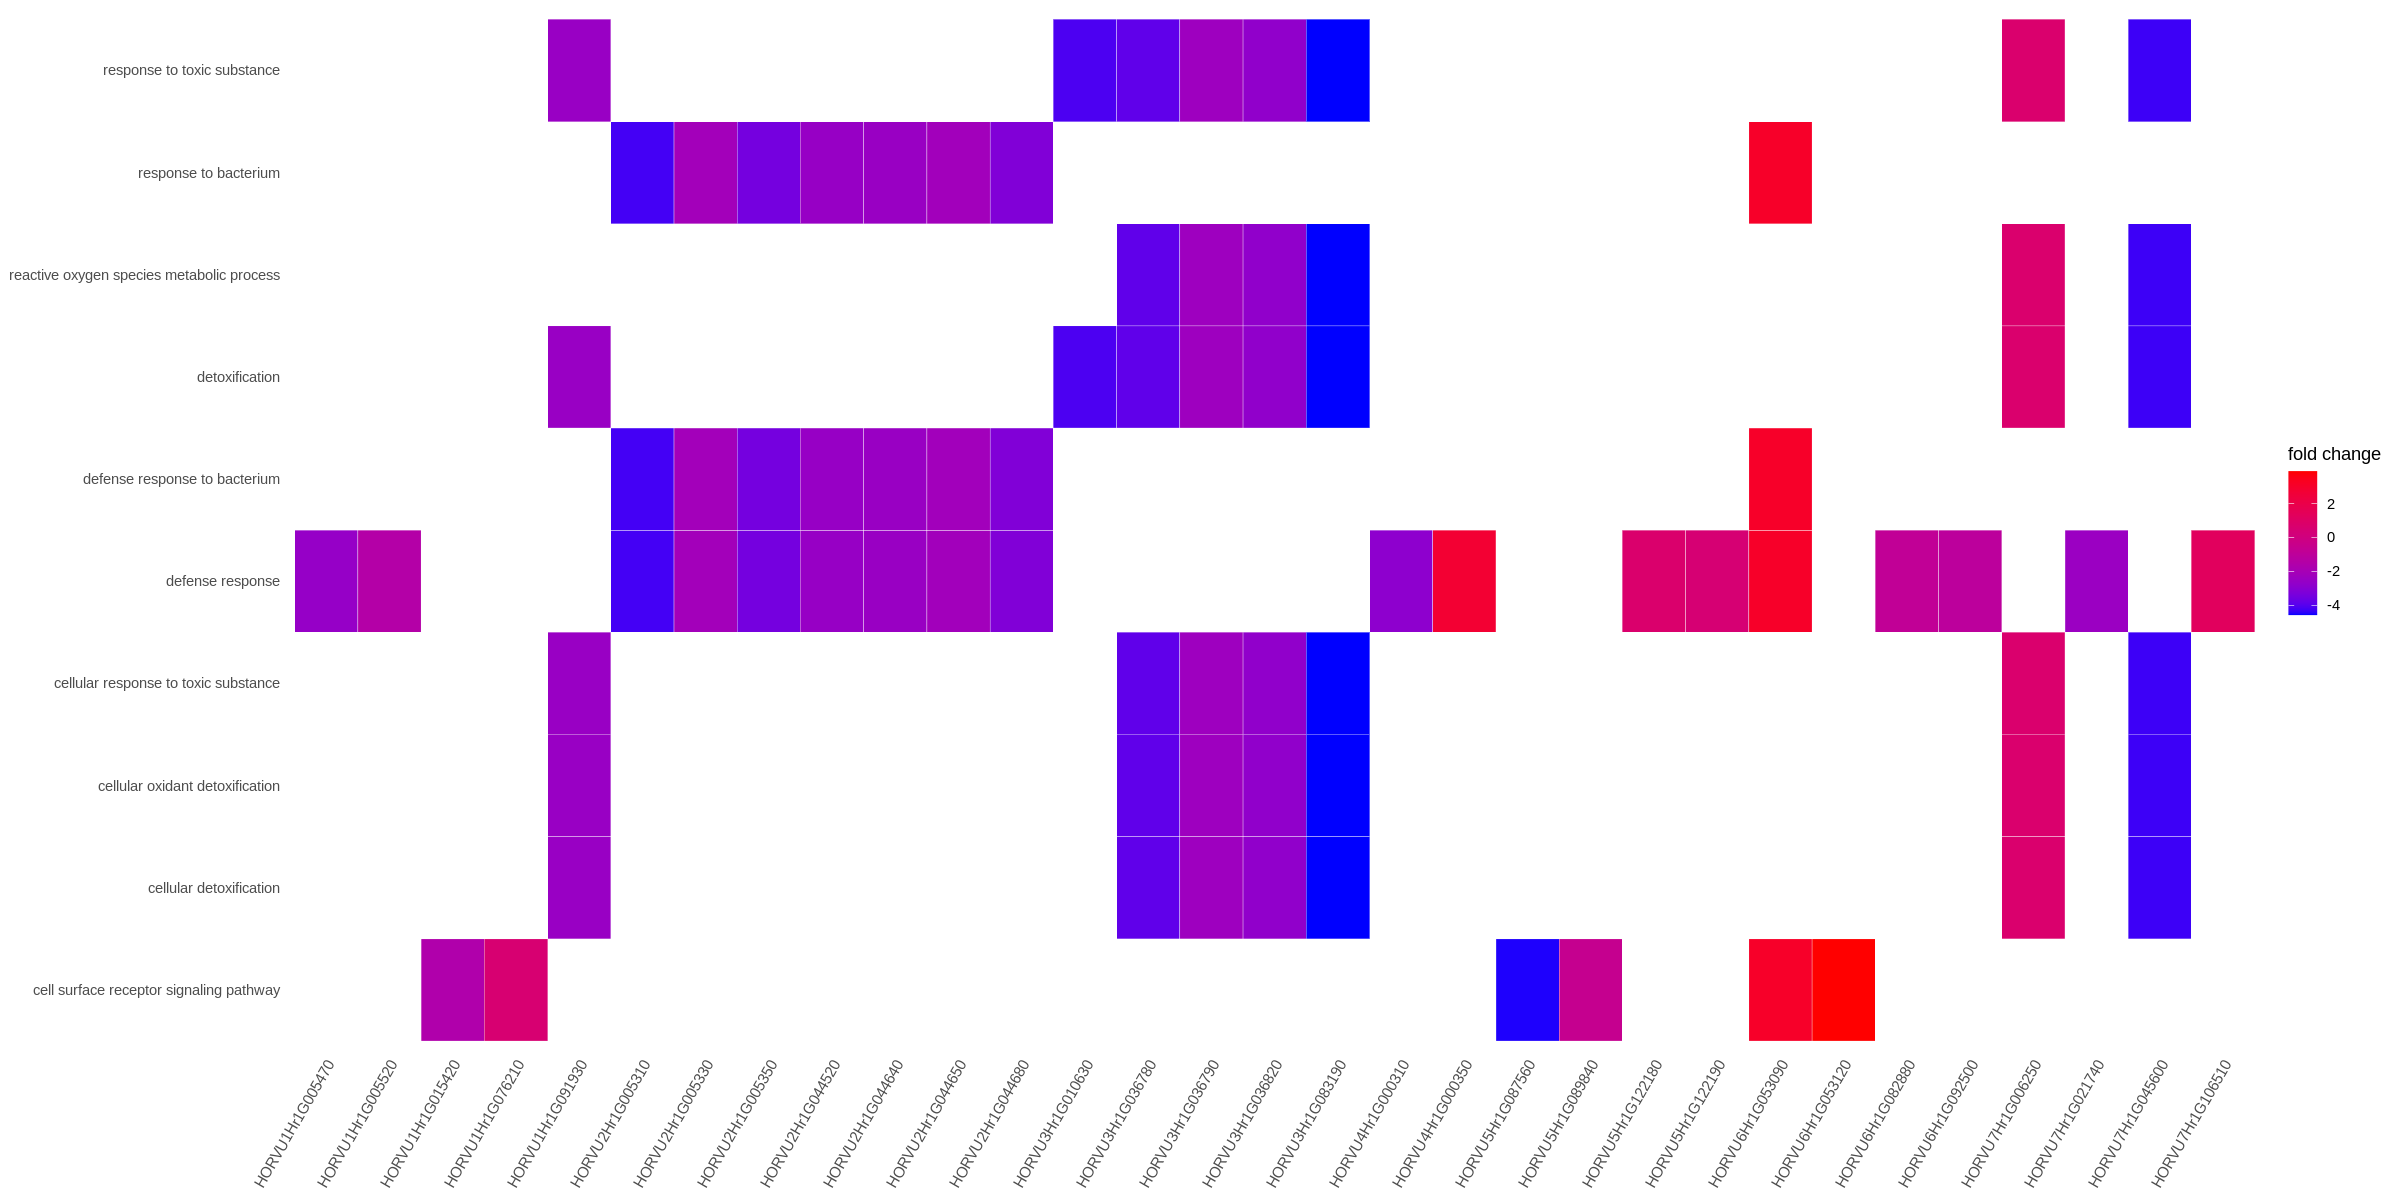

In [217]:
# Heatmap
p1 <- heatplot(resGO, showCategory=10, foldChange = qlfc_vec)
p1

Warning message:
“The "label" has(have) been found in tree data. You might need to rename the
variable(s) in the data of "geom_cladelab" to avoid this warning!”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“The "label" has(have) been found in tree data. You might need to rename the
variable(s) in the data of "geom_cladelab" to avoid this warning!”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


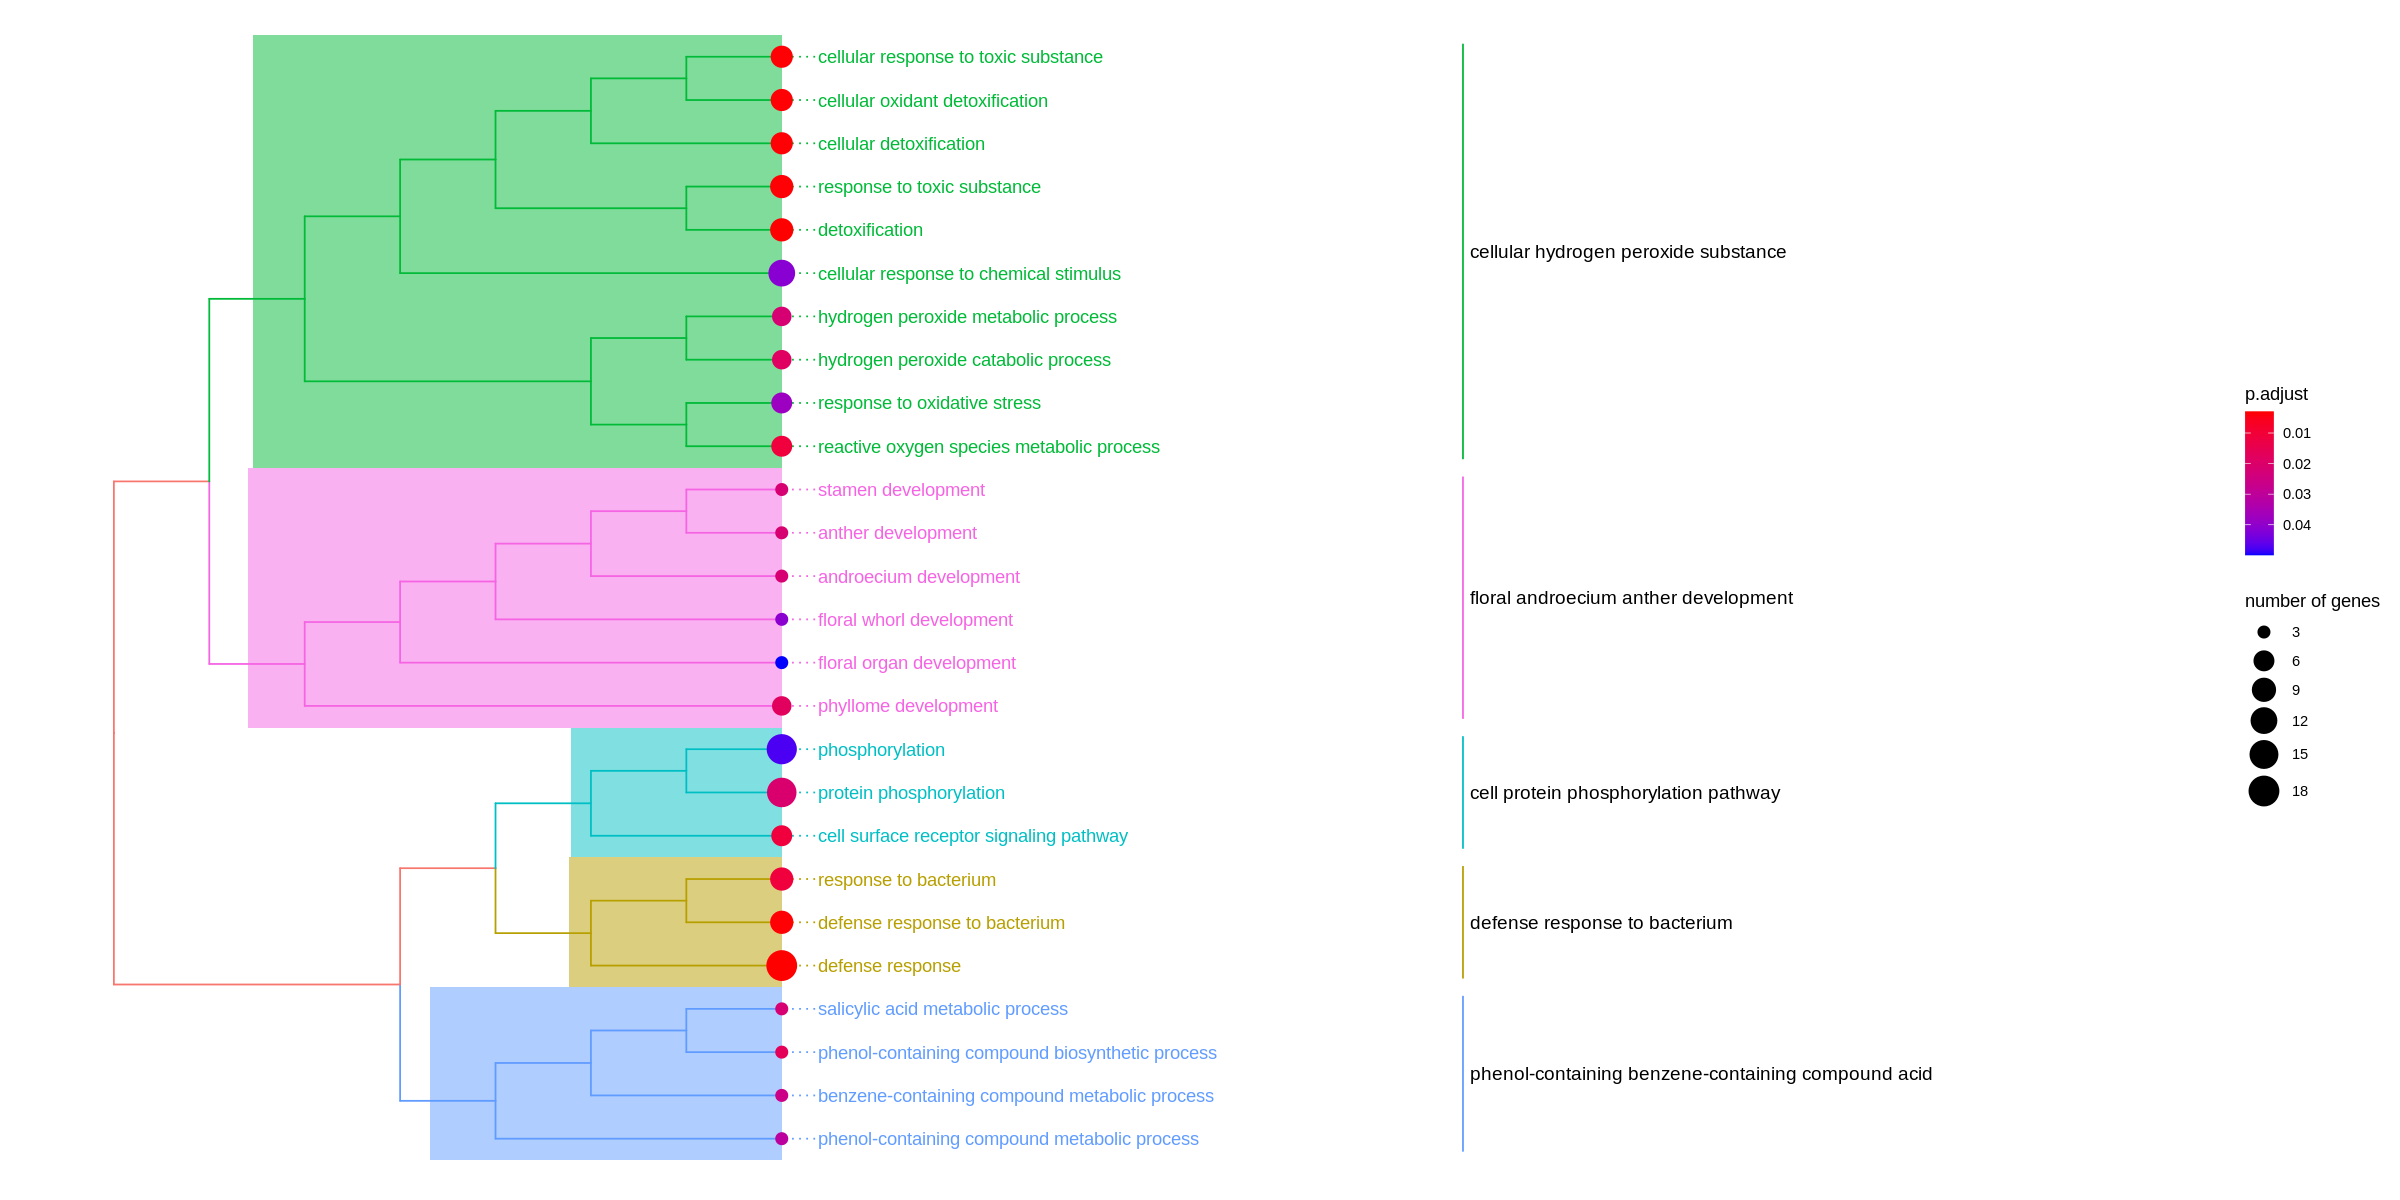

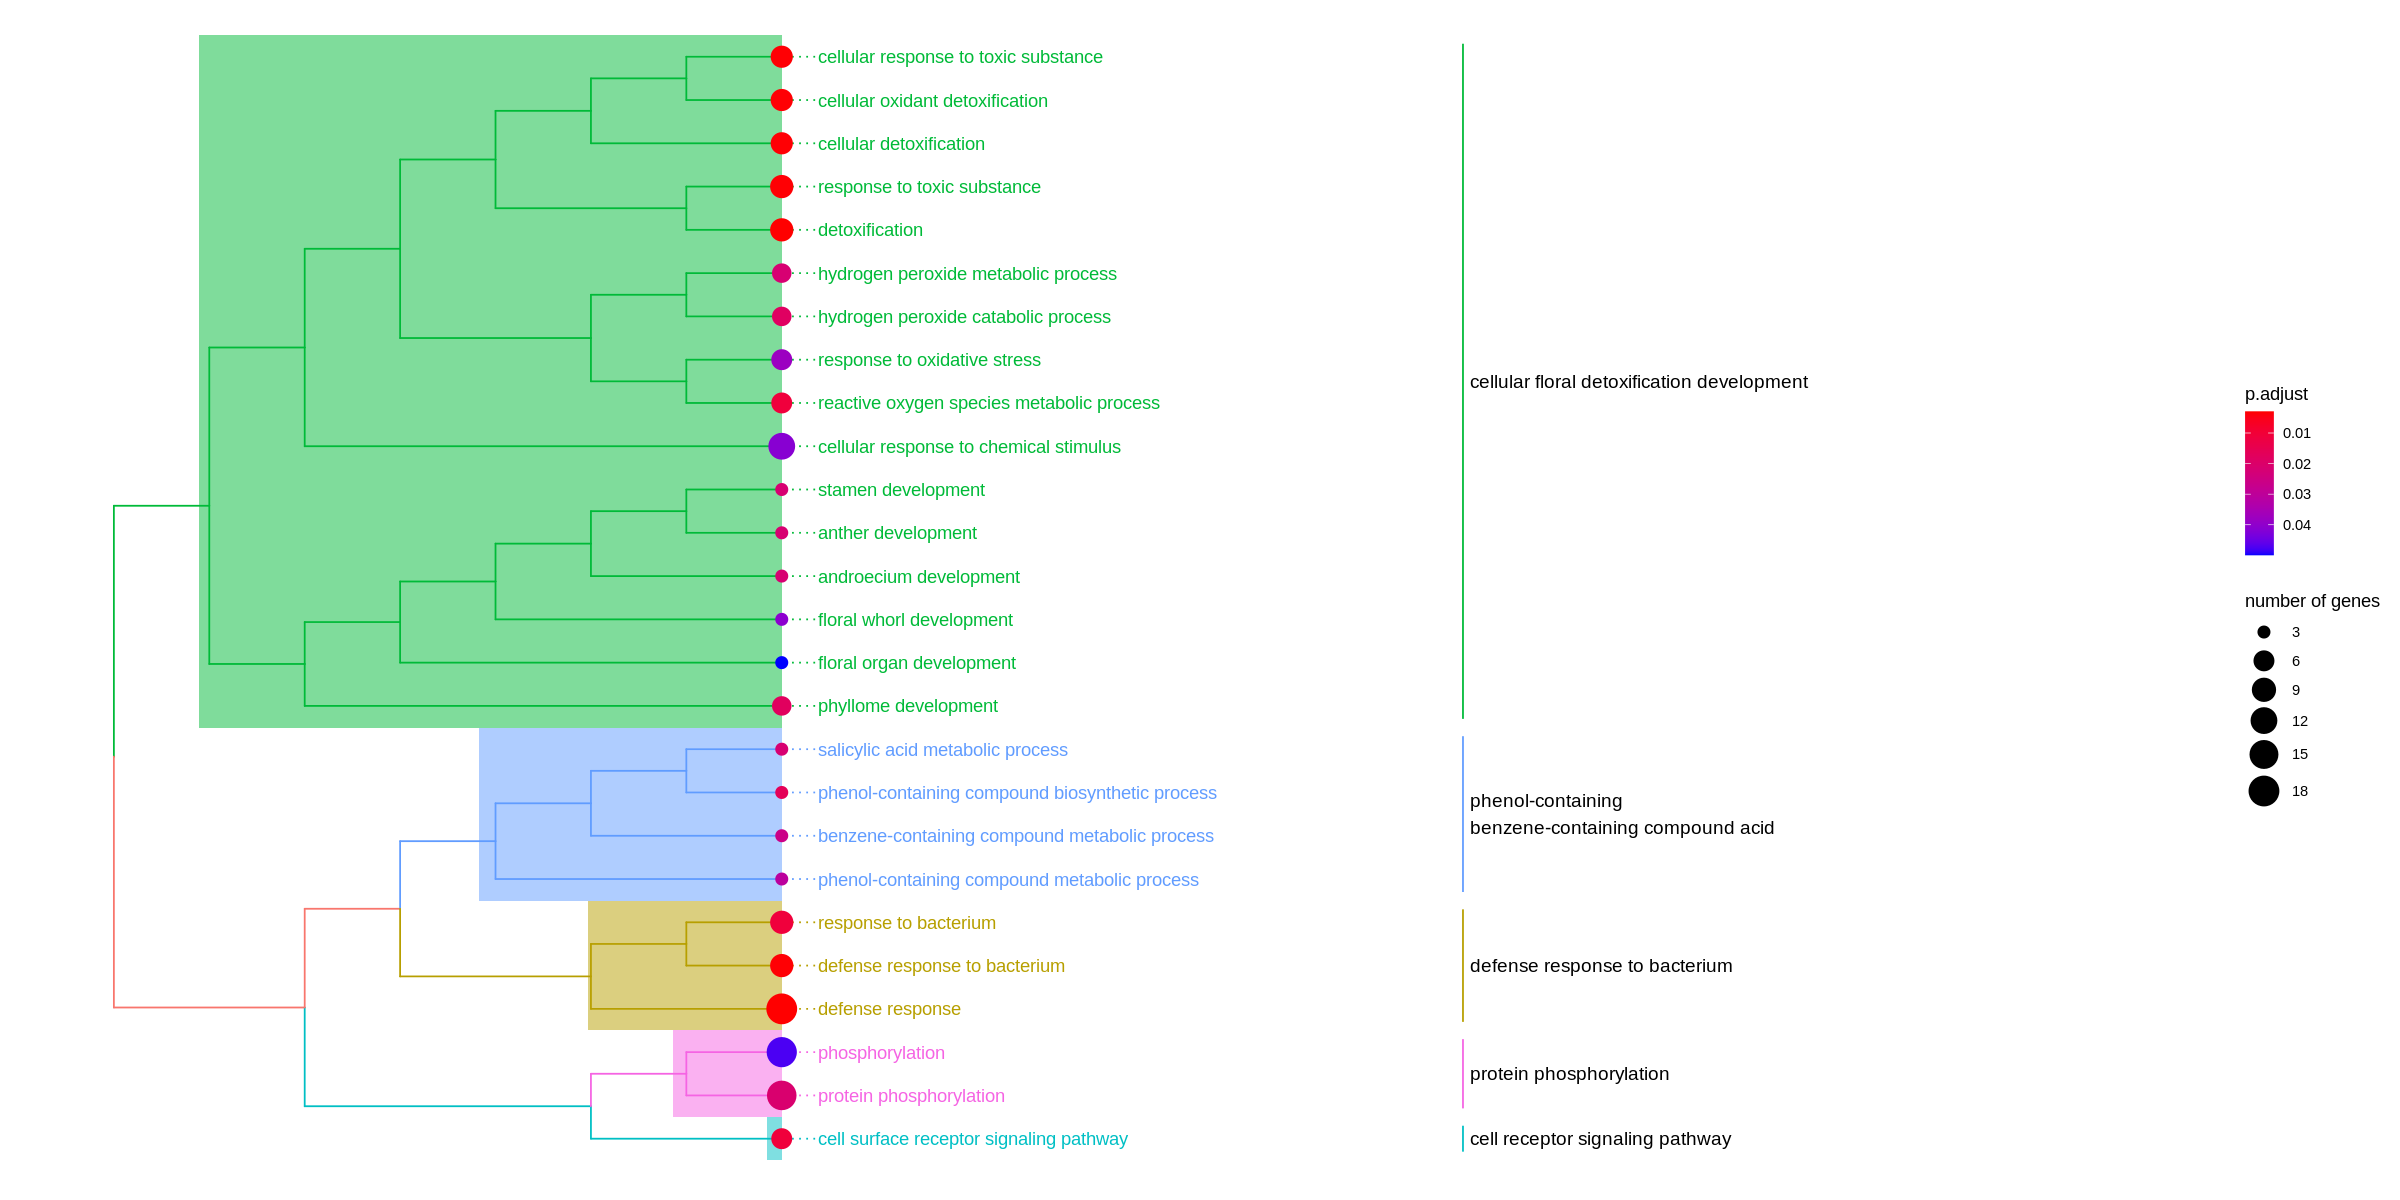

In [235]:
# Tree plot - clustering
resGO_termsim <- pairwise_termsim(resGO)
p1 <- treeplot(resGO_termsim, label_format = 400)
p1

p2 <- treeplot(resGO_termsim, hclust_method = "average")
p2
#aplot::plot_list(list(p1, p2)) + plot_annotation(tag_levels='A')

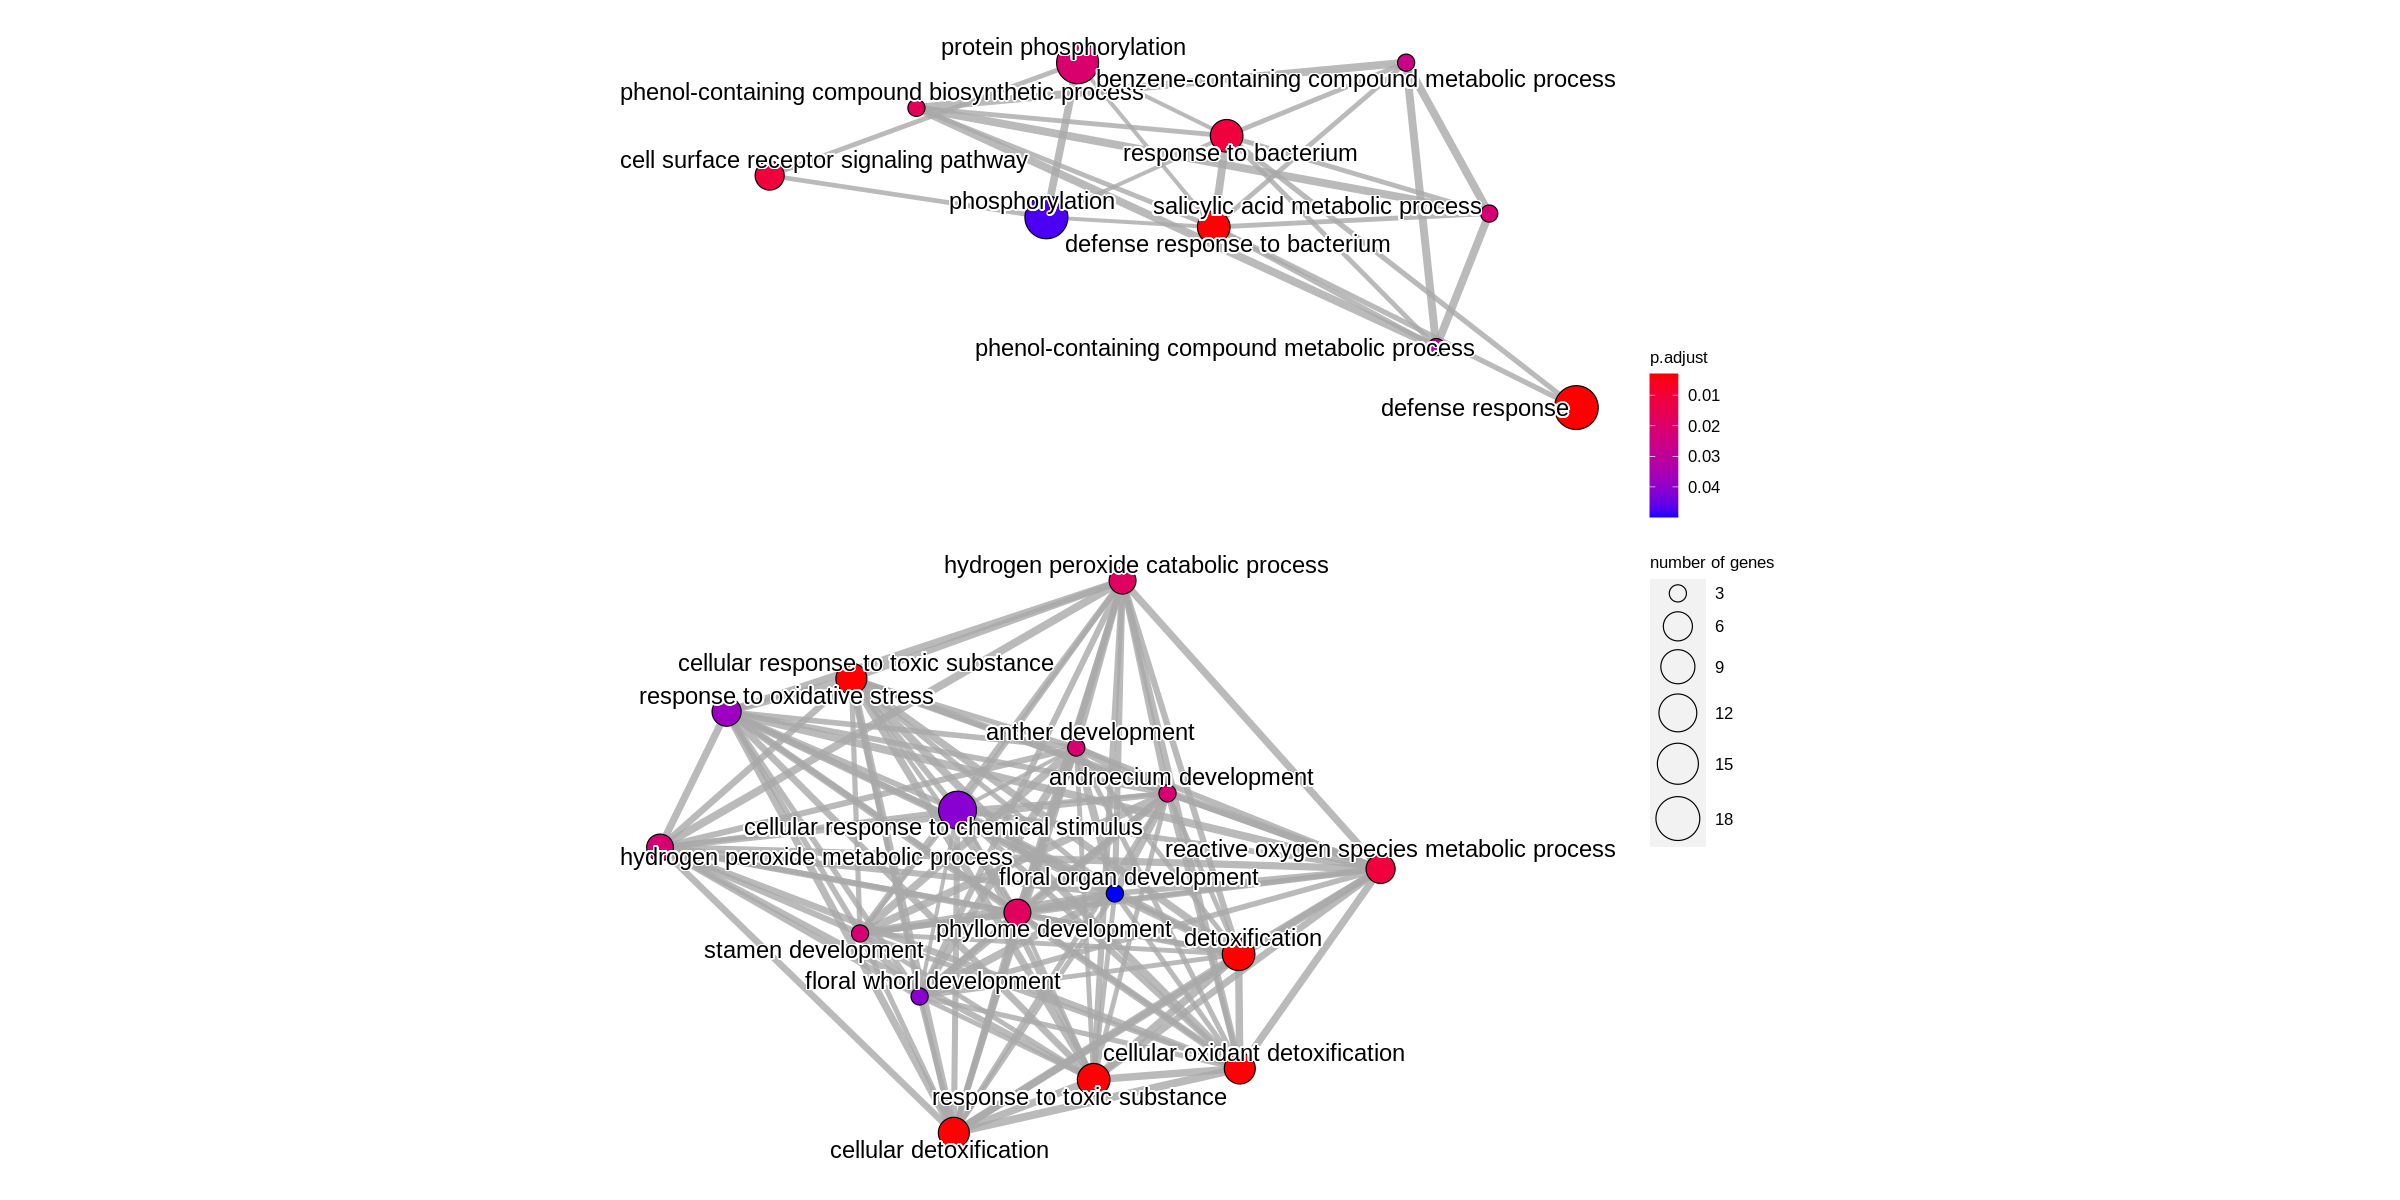

In [239]:
#Enrichment map
resGO_termsim <- pairwise_termsim(resGO)

p1 <- emapplot(resGO_termsim)
p2 <- emapplot(resGO_termsim, cex_category=1.5)
p3 <- emapplot(resGO_termsim, layout="kk")
p4 <- emapplot(resGO_termsim, cex_category=1.5,layout="kk") 

p4
#cowplot::plot_grid(p1, p2, p3, p4, ncol=2, labels=LETTERS[1:4])

Warning message:
“ggrepel: 20 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


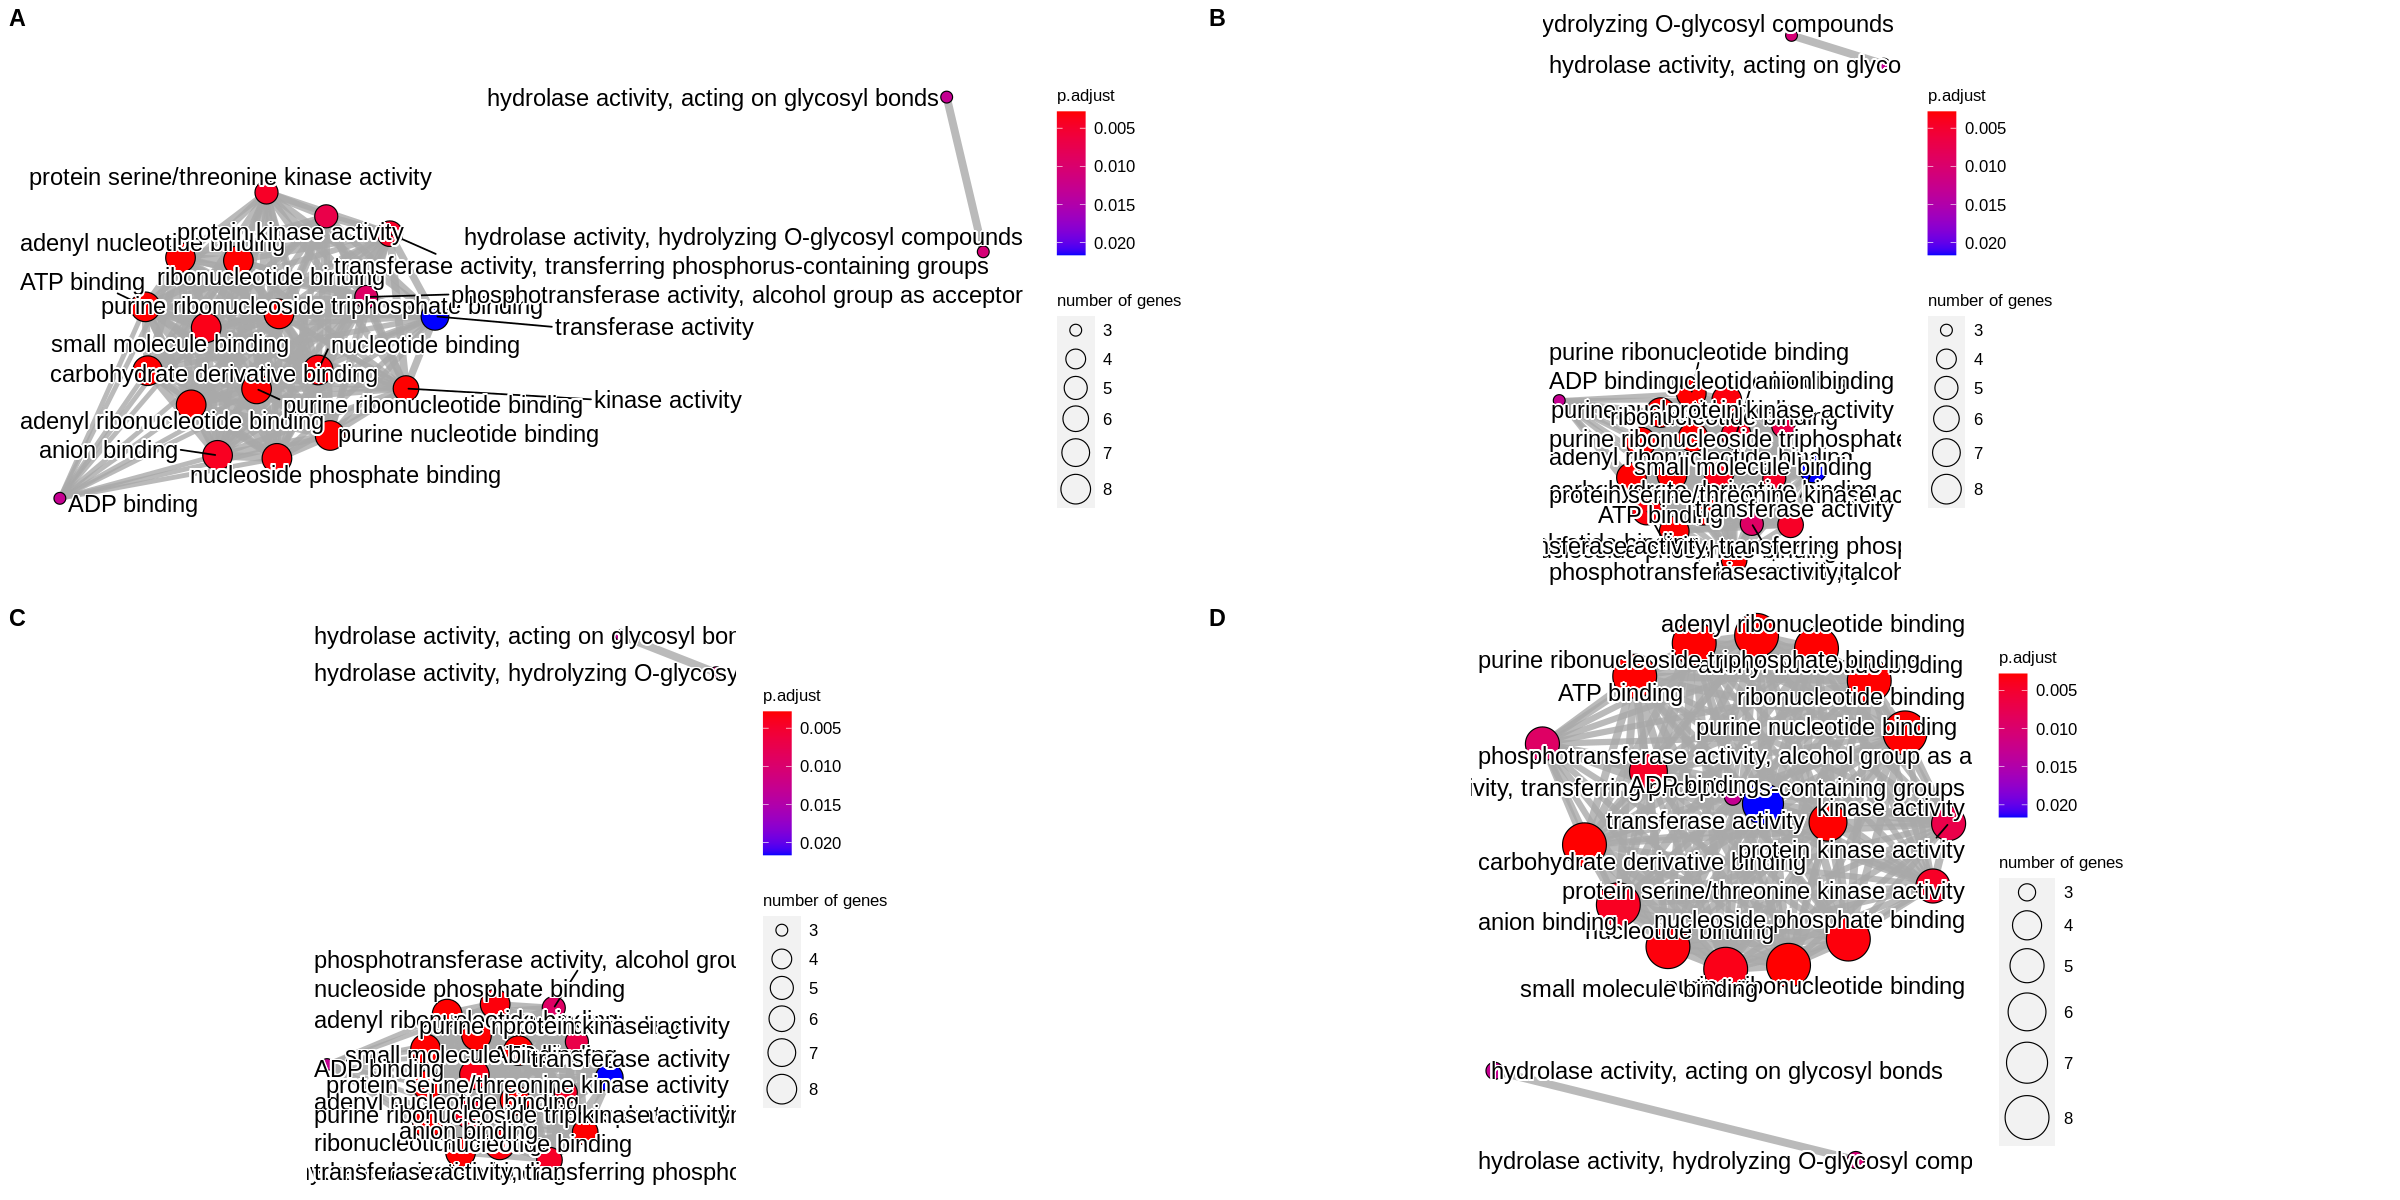

In [140]:
#Biological theme comparison

#-> could use this to display differences between
#-> up down; expanded vs compared species; all species...



#data(gcSample)
#xx <- compareCluster(gcSample, fun="enrichKEGG",
#                     organism="hsa", pvalueCutoff=0.05)
#xx <- pairwise_termsim(xx)                     
p1 <- emapplot(resGO_termsim)
p2 <- emapplot(resGO_termsim, legend_n=2) 
p3 <- emapplot(resGO_termsim, pie="count")
p4 <- emapplot(resGO_termsim, pie="count", cex_category=1.5, layout="kk")
cowplot::plot_grid(p1, p2, p3, p4, ncol=2, labels=LETTERS[1:4])

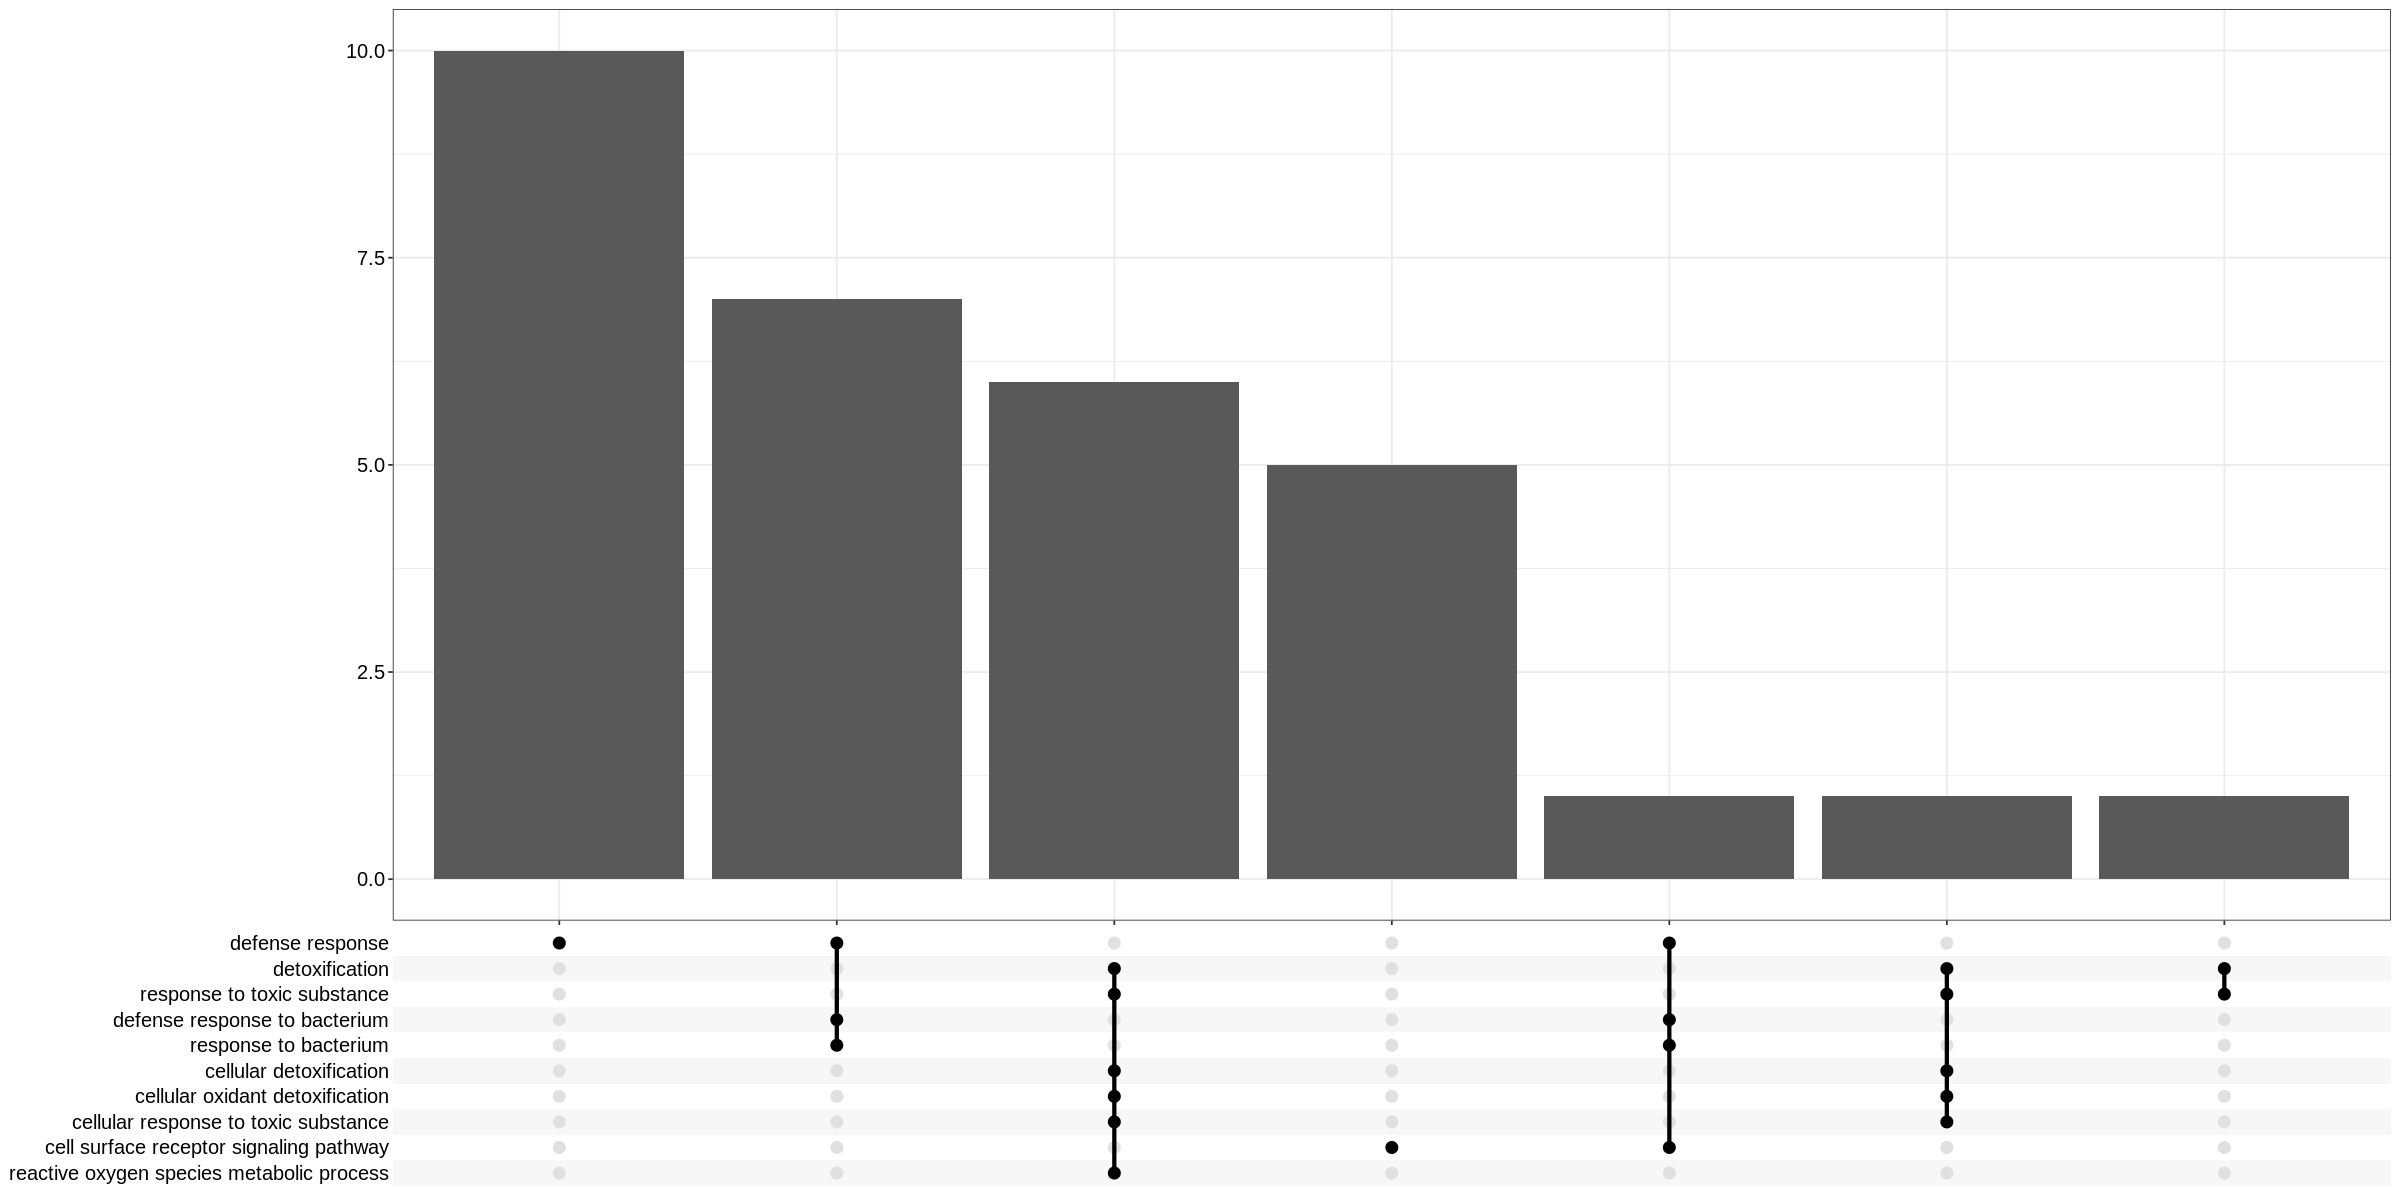

In [240]:
#install.packages("ggupset")
library(ggupset)

#The upsetplot is an alternative to cnetplot for visualizing the complex association between genes and gene sets. 
#It emphasizes the gene overlapping among different gene sets.
#For over-representation analysis, upsetplot will calculate the overlaps among different gene sets

# UpSetR plot
upsetplot(resGO)

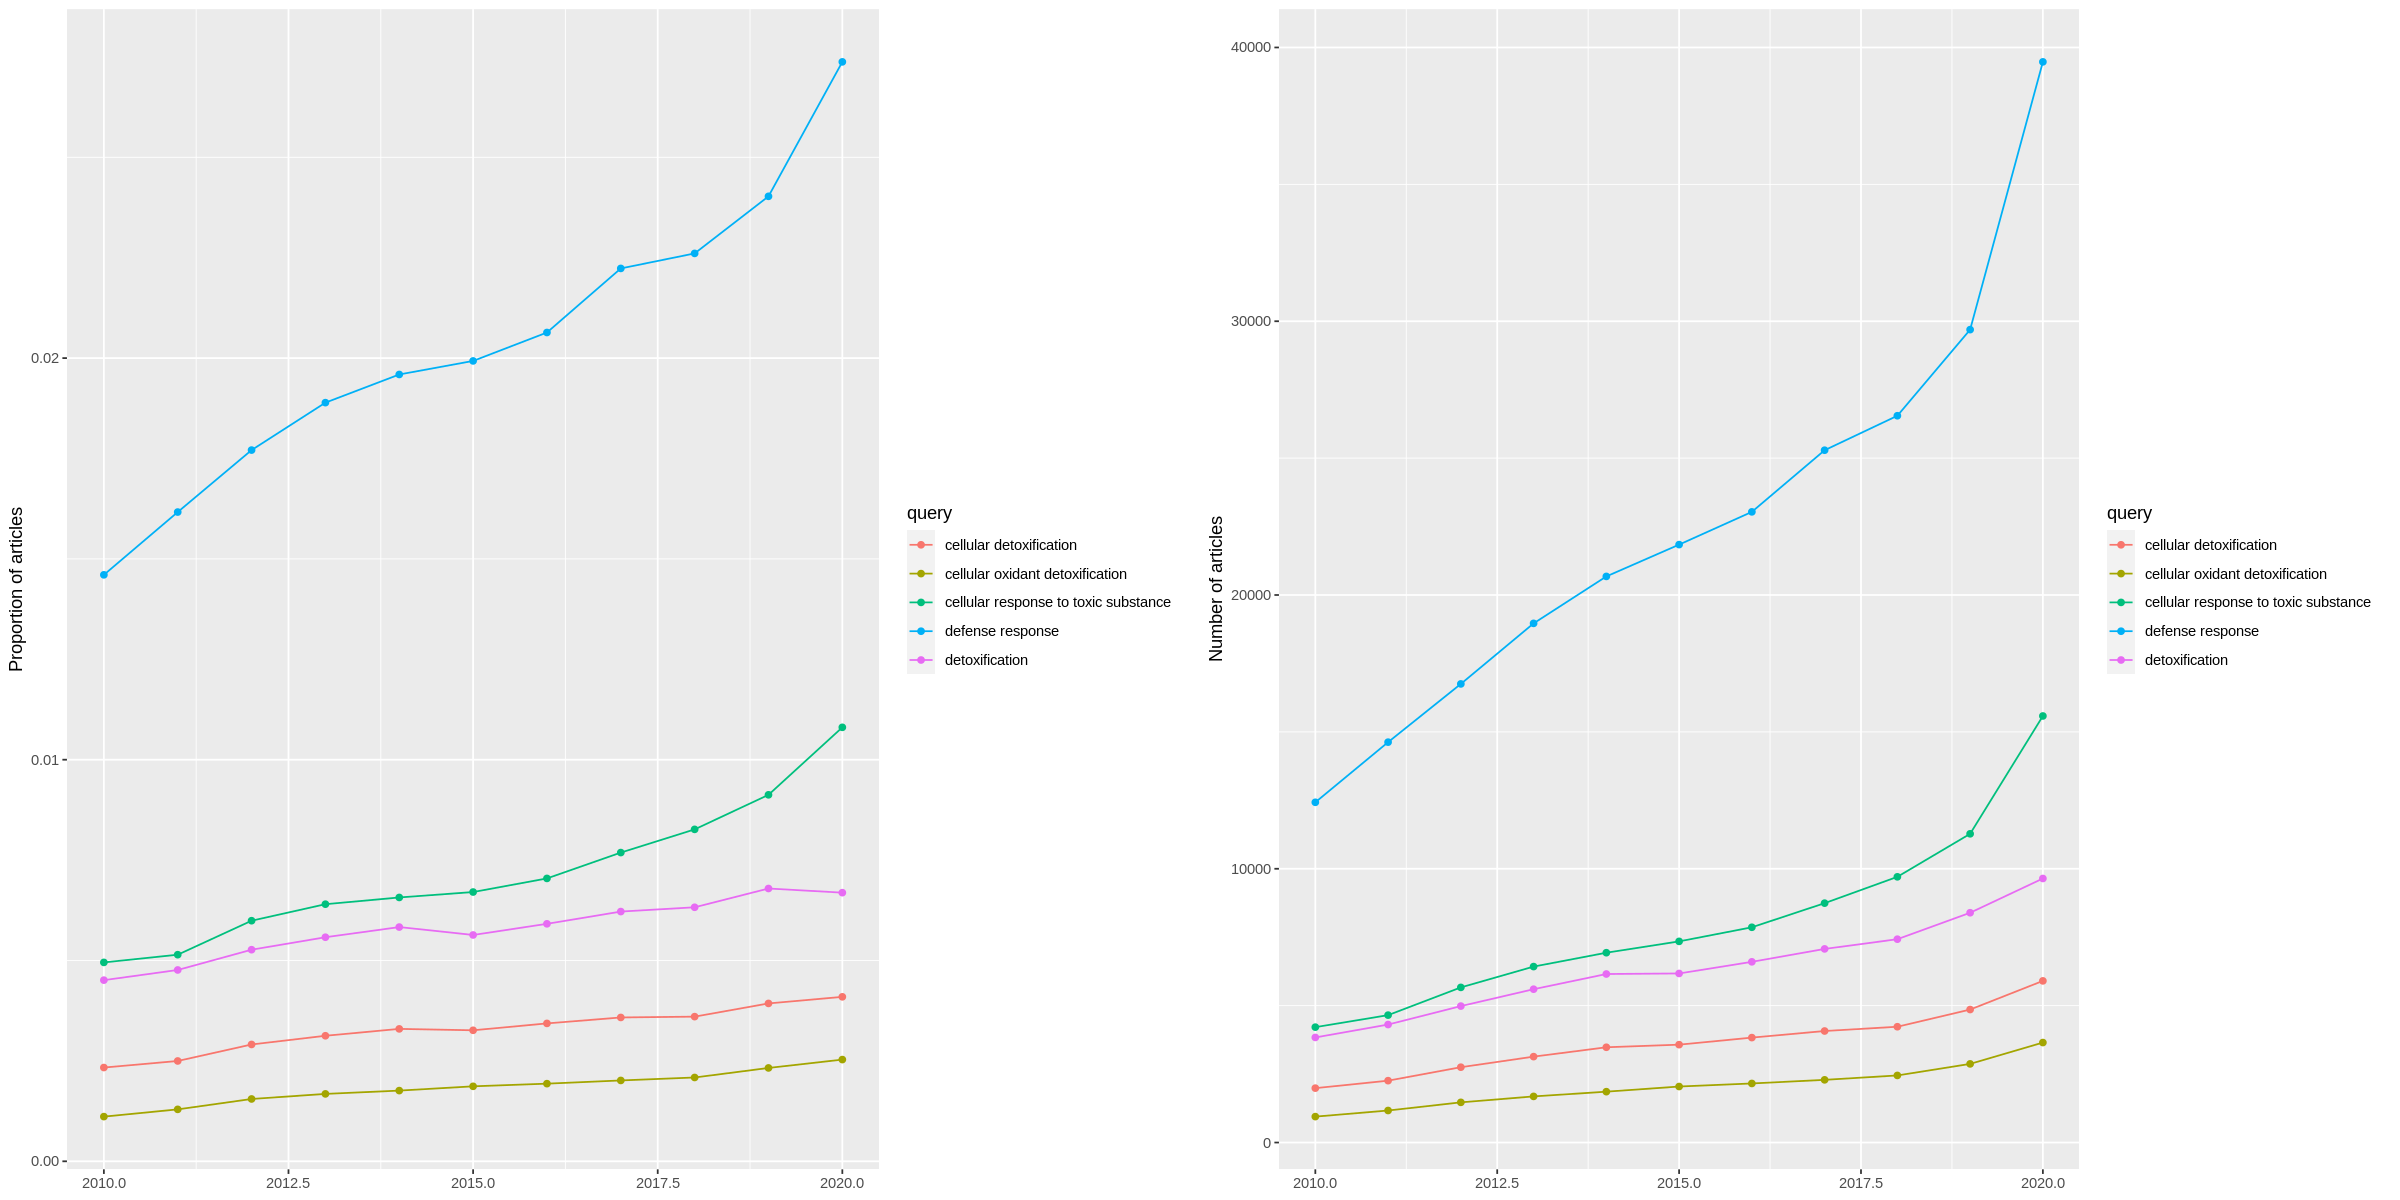

In [241]:
#install.packages("europepmc")
library(europepmc)

# pubmed trend of enriched terms
#One of the problem of enrichment analysis is to find pathways for further investigation. 
#Here, we provide pmcplot function to plot the number/proportion of publications trend based on the query result from PubMed Central. 
#Of course, users can use pmcplot in other scenarios. 
#All text that can be queried on PMC is valid as input of pmcplot.

terms <- resGO$Description[1:5]
p <- pmcplot(terms, 2010:2020)
p2 <- pmcplot(terms, 2010:2020, proportion=FALSE)
plot_grid(p, p2, ncol=2)